# Import modules

In [21]:
import sqlite3
import pandas as pd
import geopandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import ipaddress
import csv
import json
import descartes
import cartopy
import cartopy.crs as ccrs
import collections
from collections import Counter
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
from matplotlib.legend import Legend
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy.stats import gaussian_kde

# Auxiliary methods and variables

## Database file paths

In [2]:
db_path = r"D:/db/speedchecker_db.db" # file path of the Speedchecker database
db_path_ripe = r"D:/db/ripeanalysis-data.db" # file path of the RIPE Atlas database

## Global

In [58]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = ["#c1d5e2", "#ce9c7f", "#7598b6", "#6a7465", "#914c09", "#663979", "#fbe17b"]
continent_colors = {"NA": "#7598b6", "AS": "#914c09", "EU": "#ce9c7f", "AF": "#c1d5e2", 
                    "OC": "#663979", "SA": "#6a7465"}
lstyles = {"AF": "solid", "AS": "solid", "EU": "dashed", "NA": "dotted", "OC": "dashdot", "SA": "dotted"}
asns = [8075, 14061, 15169, 16509, 20473, 31898, 36351, 45102, 63949]

plt.rcParams.update({
    "text.usetex": True,
    "figure.autolayout": True})
plt.rcParams["axes.axisbelow"] = True

with open("iso3.json", mode="r", encoding="utf-8") as file:
    f = json.load(file)
country_codes = {value: key for key, value in f.items()} # create mapping from 2-letter to 3-letter country code

peeringdb = {}
with open("peeringdb.json", mode="r", encoding="utf-8") as file:
    json_obj = json.load(file)
    for elem in json_obj["data"]:
        peeringdb[elem["asn"]] = {"id": elem["id"], "org_id": elem["org_id"],
                                    "name": elem["name"], "info_type": elem["info_type"]}

def get_pdb_info(asn):
    if asn in peeringdb:
        pdb_dict = peeringdb[asn]
        return pdb_dict["name"], pdb_dict["info_type"]
    else:
        return "Unknown", "Unknown"

def create_connection(db):
    try:
        con = sqlite3.connect(db)
        return con
    except sqlite3.Error as e:
        print(e)
        
def is_private_ip(ip):
    ip_obj = ipaddress.ip_address(ip)
    return (ip_obj in ipaddress.ip_network("10.0.0.0/8") or ip_obj in ipaddress.ip_network("172.16.0.0/12")
            or ip_obj in ipaddress.ip_network("192.168.0.0/16"))

## Speedchecker

In [16]:
conn = create_connection(db_path)
cursor = conn.cursor()

probe_countries = {}
probe_continents = {}
cursor.execute("select ProbeID, Country, Continent from Probes where Country != ''")
for p_id, co, cont in cursor:
    probe_countries[p_id] = co
    probe_continents[p_id] = cont
    
def get_lowest_avg_pings(ping_type, continent, filter_provider, glob, source_continent=""):
    if glob:
        if ping_type.lower() == "tcp":
            probe_info_sql = """SELECT Ping.ProbeID, Ping1, Ping2, Ping3, Ping4, Ping5, DestinationURL, 
                             D.Provider FROM Ping JOIN Probes P ON Ping.ProbeID = P.ProbeID JOIN Datacenters D 
                             ON D.Url = Ping.DestinationURL WHERE P.Continent = D.Continent"""
        elif ping_type.lower() == "icmp":
            probe_info_sql = """WITH relevant_ids AS (
                             SELECT TracerouteID FROM Traceroute JOIN Datacenters D ON 
                             D.URL = Traceroute.DestinationURL JOIN Probes P ON P.ProbeID = Traceroute.ProbeID 
                             WHERE P.Continent = D.Continent),
                             ranked_hops AS (
                             SELECT HopNumber, TracerouteID, RTT1, RTT2, RTT3, ROW_NUMBER() OVER 
                             (PARTITION BY TracerouteID ORDER BY HopNumber DESC) AS rn FROM Hops
                             WHERE TracerouteID IN relevant_ids),
                             tracert_id_info AS (
                             SELECT ProbeID, TracerouteID, DestinationURL, D.Provider FROM Traceroute T
                             JOIN Datacenters D on D.URL = T.DestinationURL  where TracerouteID in relevant_ids)
                             SELECT T.ProbeID, RTT1, RTT2, RTT3, 0, 0, DestinationURL, 
                             Provider FROM ranked_hops R JOIN tracert_id_info T
                             ON R.TracerouteID = T.TracerouteID WHERE rn = 1 """
        else:
            print("Invalid ping type")
            return
        cursor.execute(probe_info_sql)        
    else:
        if ping_type.lower() == "tcp":
            probe_info_sql = """SELECT Ping.ProbeID, Ping1, Ping2, Ping3, Ping4, Ping5, DestinationURL, 
                             D.Provider FROM Ping JOIN Probes P ON Ping.ProbeID = P.ProbeID JOIN Datacenters D 
                             ON D.Url = Ping.DestinationURL WHERE P.Continent = ? and D.Continent = ?"""
        elif ping_type.lower() == "icmp":
            probe_info_sql = """WITH relevant_ids AS (
                             SELECT TracerouteID FROM Traceroute JOIN Datacenters D ON 
                             D.URL = Traceroute.DestinationURL JOIN Probes P ON P.ProbeID = Traceroute.ProbeID 
                             WHERE P.Continent = ? and D.Continent = ?),
                             ranked_hops AS (
                             SELECT HopNumber, TracerouteID, RTT1, RTT2, RTT3, ROW_NUMBER() OVER 
                             (PARTITION BY TracerouteID ORDER BY HopNumber DESC) AS rn FROM Hops
                             WHERE TracerouteID IN relevant_ids),
                             tracert_id_info AS (
                             SELECT ProbeID, TracerouteID, DestinationURL, D.Provider FROM Traceroute T
                             JOIN Datacenters D on D.URL = T.DestinationURL  where TracerouteID in relevant_ids)
                             SELECT T.ProbeID, RTT1, RTT2, RTT3, 0, 0, DestinationURL, 
                             Provider FROM ranked_hops R JOIN tracert_id_info T
                             ON R.TracerouteID = T.TracerouteID WHERE rn = 1 """
        else:
            print("Invalid ping type")
            return
        if source_continent:
            cursor.execute(probe_info_sql, (source_continent, continent))
        else:
            cursor.execute(probe_info_sql, (continent, continent))
    probe_ping_dict = {}
    for probe in cursor:
        probe_id = probe[0]
        dc = probe[6]
        if probe_id not in probe_ping_dict:
            probe_ping_dict[probe_id] = {}
        if filter_provider:
            provider = probe[7]
            if provider not in probe_ping_dict[probe_id]:
                probe_ping_dict[probe_id][provider] = {}
            if dc not in probe_ping_dict[probe_id][provider]:
                probe_ping_dict[probe_id][provider][dc] = []
            probe_ping_dict[probe_id][provider][dc] += [p for p in probe[1:6] if
                                                        p is not None and 0 < p < 1000]
        else:
            if dc not in probe_ping_dict[probe_id]:
                probe_ping_dict[probe_id][dc] = []
            probe_ping_dict[probe_id][dc] += [p for p in probe[1:6] if p is not None and 0 < p < 1000]   
    return probe_ping_dict

def get_lowest_avg_ping_unfiltered_geo(ping_type, continent="", country=True, glob=False, 
                                       source_continent="", minimum=False):
    result_pings = {}
    probe_ping_dict = get_lowest_avg_pings(ping_type, continent, False, glob, source_continent)
    for probe_id in probe_ping_dict:
        lowest = ()
        for dc in probe_ping_dict[probe_id]:
            pings = probe_ping_dict[probe_id][dc]
            if len(pings) > 0:
                avg = sum(pings)/len(pings)
                if lowest == ():
                    lowest = (dc, avg)
                elif avg < lowest[1]:
                    lowest = (dc, avg)
        if lowest != ():
            if country:
                co = probe_countries[probe_id]
                if co not in result_pings:
                    result_pings[co] = []
            else:
                co = probe_continents[probe_id]
                if co not in result_pings:
                    result_pings[co] = []
            if minimum:
                result_pings[co].append(min(probe_ping_dict[probe_id][lowest[0]]))
            else:
                result_pings[co] += probe_ping_dict[probe_id][lowest[0]]
    return result_pings

## RIPE Atlas

In [6]:
conn_ripe = create_connection(db_path_ripe)
cursor_ripe = conn_ripe.cursor()

probe_countries_ripe = {}
probe_continents_ripe = {}
cursor_ripe.execute("select ID, Country, Continent from Probes where Country != ''")
for p_id, co, cont in cursor_ripe:
    probe_countries_ripe[p_id] = co
    probe_continents_ripe[p_id] = cont
    
cursor_ripe.execute("select ID from Probes where home = 1")
home_ids = [x[0] for x in cursor_ripe]

def get_lowest_avg_pings_ripe(ping_type, continent, filter_provider, glob, source_continent=""):
    if glob:
        if ping_type.lower() == "icmp":
            probe_info_sql = """SELECT Pi.probe_id, Ping1, Ping2, Ping3, Ping4, Ping5, Pi.url,  
                             D.name FROM Ping Pi JOIN Probes P ON Pi.probe_id = P.ID JOIN Datacenter D  
                             ON D.Url = Pi.url WHERE P.Continent = D.Continent"""
        elif ping_type.lower() == "tcp":
            probe_info_sql = """WITH relevant_ids AS (
                             SELECT TI.ID FROM TracerouteInfo TI JOIN Datacenter D ON  
                             D.ID = TI.datacenter JOIN Probes P ON P.ID = TI.probe_id JOIN Traceroute T ON T.ID = TI.ID  
                             WHERE P.Continent = D.Continent and protocol = 'TCP'), 
                             ranked_hops AS ( 
                             SELECT Traceroute_ID, rtt_after, ROW_NUMBER() OVER  
                             (PARTITION BY Traceroute_ID, attempt ORDER BY hop_number DESC) AS rn FROM Hops  
                             WHERE Traceroute_ID IN relevant_ids), 
                             tracert_id_info AS ( 
                             SELECT TI.probe_id, TI.ID, TI.url, D.name FROM TracerouteInfo TI JOIN Datacenter D on  
                             TI.datacenter = D.ID where TI.ID in relevant_ids)
                             SELECT T.probe_id, rtt_after, url,  
                             name FROM ranked_hops R JOIN tracert_id_info T  
                             ON R.Traceroute_ID = T.ID WHERE rn = 1"""
        cursor_ripe.execute(probe_info_sql)
    else:
        if ping_type.lower() == "icmp":
            probe_info_sql = """SELECT Pi.probe_id, Ping1, Ping2, Ping3, Ping4, Ping5, Pi.url,  
                             D.name FROM Ping Pi JOIN Probes P ON Pi.probe_id = P.ID JOIN Datacenter D  
                             ON D.Url = Pi.url WHERE P.Continent = ? and D.Continent = ?"""
        elif ping_type.lower() == "tcp":
            probe_info_sql = """WITH relevant_ids AS (
                             SELECT TI.ID FROM TracerouteInfo TI JOIN Datacenter D ON  
                             D.ID = TI.datacenter JOIN Probes P ON P.ID = TI.probe_id JOIN Traceroute T ON T.ID = TI.ID  
                             WHERE P.Continent = ? and D.Continent = ? and protocol = 'TCP'), 
                             ranked_hops AS ( 
                             SELECT Traceroute_ID, rtt_after, ROW_NUMBER() OVER  
                             (PARTITION BY Traceroute_ID, attempt ORDER BY hop_number DESC) AS rn FROM Hops  
                             WHERE Traceroute_ID IN relevant_ids), 
                             tracert_id_info AS ( 
                             SELECT TI.probe_id, TI.ID, TI.url, D.name FROM TracerouteInfo TI JOIN Datacenter D on  
                             TI.datacenter = D.ID where TI.ID in relevant_ids)
                             SELECT T.probe_id, rtt_after, url,  
                             name FROM ranked_hops R JOIN tracert_id_info T  
                             ON R.Traceroute_ID = T.ID WHERE rn = 1"""
        if source_continent:
            cursor_ripe.execute(probe_info_sql, (source_continent, continent))
        else:
            cursor_ripe.execute(probe_info_sql, (continent, continent))
    probe_ping_dict = {}
    if ping_type.lower() == "icmp":
        for probe in cursor_ripe:            
            probe_id = probe[0]
            dc = probe[6]
            if probe_id not in probe_ping_dict:
                probe_ping_dict[probe_id] = {}
            if filter_provider:
                provider = probe[7]
                if provider not in probe_ping_dict[probe_id]:
                    probe_ping_dict[probe_id][provider] = {}
                if dc not in probe_ping_dict[probe_id][provider]:
                    probe_ping_dict[probe_id][provider][dc] = []
                probe_ping_dict[probe_id][provider][dc] += [p for p in probe[1:6] if
                                                            p is not None and 0 < p < 1000]
            else:
                if dc not in probe_ping_dict[probe_id]:
                    probe_ping_dict[probe_id][dc] = []
                probe_ping_dict[probe_id][dc] += [p for p in probe[1:6] if p is not None and 0 < p < 1000]   
    else:
        for probe in cursor_ripe:
            probe_id = probe[0]
            dc = probe[2]
            if probe_id not in probe_ping_dict:
                probe_ping_dict[probe_id] = {}
            if filter_provider:
                provider = probe[3]
                if provider not in probe_ping_dict[probe_id]:
                    probe_ping_dict[probe_id][provider] = {}
                if dc not in probe_ping_dict[probe_id][provider]:
                    probe_ping_dict[probe_id][provider][dc] = []
                if probe[1] > 0:    
                    probe_ping_dict[probe_id][provider][dc].append(probe[1])
            else:
                if dc not in probe_ping_dict[probe_id]:
                    probe_ping_dict[probe_id][dc] = []
                if probe[1] > 0: 
                    probe_ping_dict[probe_id][dc].append(probe[1])
    return probe_ping_dict

def get_lowest_avg_ping_unfiltered_geo_ripe(ping_type, continent="", country=True, glob=False, source_continent="", minimum=False):
    result_pings = {}
    probe_ping_dict = get_lowest_avg_pings_ripe(ping_type, continent, False, glob, source_continent)
    for probe_id in probe_ping_dict:
        lowest = ()
        for dc in probe_ping_dict[probe_id]:
            pings = probe_ping_dict[probe_id][dc]
            if len(pings) > 0:
                avg = sum(pings)/len(pings)
                if lowest == ():
                    lowest = (dc, avg)
                elif avg < lowest[1]:
                    lowest = (dc, avg)
        if lowest != ():
            if country:
                co = probe_countries_ripe[probe_id]
                if co not in result_pings:
                    result_pings[co] = []
            else:
                co = probe_continents_ripe[probe_id]
                if co not in result_pings:
                    result_pings[co] = []
            if minimum:
                result_pings[co].append(min(probe_ping_dict[probe_id][lowest[0]]))
            else:
                result_pings[co] += probe_ping_dict[probe_id][lowest[0]]
    return result_pings

def get_lowest_avg_ping_unfiltered_geo_ripe_home(ping_type, continent="", country=True, glob=False, source_continent="", minimum=False):
    result_pings = {}
    probe_ping_dict = get_lowest_avg_pings_ripe(ping_type, continent, False, glob, source_continent)
    for probe_id in probe_ping_dict:
        if probe_id in home_ids:
            lowest = ()
            for dc in probe_ping_dict[probe_id]:
                pings = probe_ping_dict[probe_id][dc]
                if len(pings) > 0:
                    avg = sum(pings)/len(pings)
                    if lowest == ():
                        lowest = (dc, avg)
                    elif avg < lowest[1]:
                        lowest = (dc, avg)
            if lowest != ():
                if country:
                    co = probe_countries_ripe[probe_id]
                    if co not in result_pings:
                        result_pings[co] = []
                else:
                    co = probe_continents_ripe[probe_id]
                    if co not in result_pings:
                        result_pings[co] = []
                if minimum:
                    result_pings[co].append(min(probe_ping_dict[probe_id][lowest[0]]))
                else:
                    result_pings[co] += probe_ping_dict[probe_id][lowest[0]]
    return result_pings

# Figure 1 - Datacenter and vantage point world maps

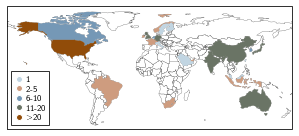

In [7]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica

cursor.execute("select Country, count(*) from Datacenters group by Country")
loc_sql_dict = {country: num for country, num in cursor}
    
country_count = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_count.append(loc_sql_dict[country_codes["FRA"]])
    elif name == "Norway":
        country_count.append(loc_sql_dict[country_codes["NOR"]])
    elif code == "-99":
        country_count.append(float("NaN"))
    elif country_codes[code] in loc_sql_dict:
        country_count.append(loc_sql_dict[country_codes[code]])
    else:
        country_count.append(float("NaN"))
world["count"] = country_count

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["1", "2-5", "6-10", "11-20", "$>$20"]
cmap = colors.ListedColormap(cols[:-2])
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
world.plot(facecolor ="white", edgecolor="black", ax=ax, linewidth=0.2)
world.plot(column="count", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[1,5,10,20]), ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
fig.tight_layout()

plt.savefig("Figs/Fig_1a.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

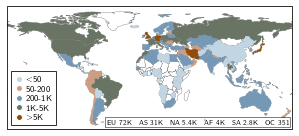

In [8]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

cursor.execute("""select Country, count(*) from Probes where ProbeID in (SELECT distinct(ProbeID)
from Ping union select distinct(ProbeID) from Traceroute) 
and Country is not NULL and Country != '' group by Country order by count(*)""")
probe_sql_dict = {}
for country, num in cursor:
    probe_sql_dict[country] = num

# add probe numbers to the dataframe
probe_numbers = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        probe_numbers.append(probe_sql_dict[country_codes["FRA"]])
    elif name == "Norway":
        probe_numbers.append(probe_sql_dict[country_codes["NOR"]])
    elif code == "-99":
        probe_numbers.append(float("NaN"))
    elif country_codes[code] in probe_sql_dict:
        probe_numbers.append(probe_sql_dict[country_codes[code]])
    else:
        probe_numbers.append(float("NaN"))
world["probe_num"] = probe_numbers

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$50", "50-200", "200-1K", "1K-5K", "$>$5K"]
cmap = colors.ListedColormap(cols[:-2])
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
world.plot(facecolor ="white", edgecolor="black", ax=ax, linewidth=0.2)
world.plot(column="probe_num", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[50,200,1000,5000]), ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
ax.text(0.35, 0.03, "EU 72K\ \ \ AS 31K\ \ \ NA 5.4K\ \ \ AF 4K\ \ \ SA 2.8K\ \ \ OC 351", 
        transform=ax.transAxes, fontsize="x-small", verticalalignment="bottom", 
        bbox=dict(boxstyle="Square, pad=0.25", facecolor="none", edgecolor="black", lw=0.5))

plt.savefig("Figs/Fig_1b.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# Figure 2 - RIPE Atlas VP map

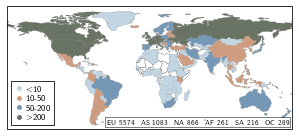

In [9]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

cursor_ripe.execute("""select Country, count(*) from Probes where ID in (SELECT distinct(probe_id)
from Ping union select distinct(probe_id) from TracerouteInfo) 
and Country is not NULL and Country != '' group by Country""")
probe_sql_dict = {}
for country, num in cursor_ripe:
    probe_sql_dict[country] = num
    
probe_numbers = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        probe_numbers.append(probe_sql_dict["FRA"])
    elif name == "Norway":
        probe_numbers.append(probe_sql_dict["NOR"])
    elif code == "-99":
        probe_numbers.append(float("NaN"))
    elif code in probe_sql_dict:
        probe_numbers.append(probe_sql_dict[code])
    else:
        probe_numbers.append(float("NaN"))
world["probe_num"] = probe_numbers

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$10", "10-50", "50-200", "$>$200"]
cmap = colors.ListedColormap(cols[:-3])
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
world.plot(facecolor ="white", edgecolor="black", ax=ax, linewidth=0.2)
world.plot(column="probe_num", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[10,50,200]), ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")
ax.text(0.35, 0.03, "EU 5574\ \ \ AS 1083\ \ \ NA 866\ \ \ AF 261\ \ \ SA 216\ \ \ OC 289", 
        transform=ax.transAxes, fontsize="x-small", verticalalignment="bottom", 
        bbox=dict(boxstyle="Square, pad=0.25", facecolor="none", edgecolor="black", lw=0.5))

plt.savefig("Figs/Fig_2.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

# Figure 3 - Ping latency world map

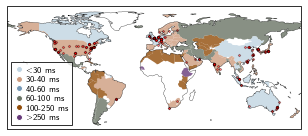

In [10]:
dc_loc_sql = "select URL, Latitude, Longitude from Datacenters"
df = pd.read_sql(dc_loc_sql, conn)
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]

results = get_lowest_avg_ping_unfiltered_geo("tcp", glob=True)
for co in results:
    results[co] = np.median(results[co]) if len(results[co]) > 0 else 0

pings = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        pings.append(results[country_codes["FRA"]])
    elif name == "Norway":
        pings.append(results[country_codes["NOR"]])
    elif code == "-99":
        pings.append(float("nan"))
    elif country_codes[code] in results:
        pings.append(results[country_codes[code]])
    else:
        pings.append(float("nan"))
world["avg_ping"] = pings

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-1])
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
labels = ["$<$30 ms", "30-40 ms", "40-60 ms", "60-100 ms", "100-250 ms", "$>$250 ms"]
ax.coastlines(linewidth=0.3)
world.plot(column="avg_ping", cmap=cmap, scheme='UserDefined', classification_kwds=dict(bins=[30,60,100,250]),
           ax=ax, alpha=0.8)
gdf.plot(marker="D", facecolor="red", edgecolor="black", ax=ax, markersize=4, linewidth=0.5, alpha=0.5)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

fig.tight_layout()
plt.savefig("Figs/Fig_3.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 4 - Ping latency CDF

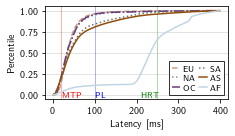

In [23]:
tcp_pings = get_lowest_avg_ping_unfiltered_geo("tcp", country=False, glob=True)
    
fig, ax = plt.subplots(figsize=(3.37, 2))
ax.axvline(x=20, linewidth=1, color="red", linestyle="-", alpha=0.3)
ax.axvline(x=100, linewidth=1, color="blue", linestyle="-", alpha=0.3)
ax.axvline(x=250, linewidth=1, color="green", linestyle="-", alpha=0.3)
for cont in ["EU", "NA", "OC", "SA", "AS", "AF"]:
    xs = np.sort(list(filter(lambda x: x < 400, tcp_pings[cont]))) # filter out outliers above 400 ms
    ys = np.arange(1, len(xs) + 1) / len(xs)
    indices = []
    current = xs[0]
    for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
        if x != current:
            current = x
            indices.append(i - 1)
    indices.append(len(ys) - 1)
    xs = sorted(set(xs))
    ys = [ys[i] for i in indices]
    ax.plot(xs, ys, label=cont, color=continent_colors[cont], linestyle=lstyles[cont])
ax.set_xlabel("Latency [ms]")
ax.set_ylabel("Percentile")
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
ax.text(22, -0.03, "MTP", color="red", size="small")
ax.text(102, -0.03, "PL", color="blue", size="small")
ax.text(210, -0.03, "HRT", color="green", size="small")

fig.tight_layout()
plt.savefig("Figs/Fig_4.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 5 - Speedchecker vs RIPE Atlas latency difference (takes ~3 hours to calculate and plot)

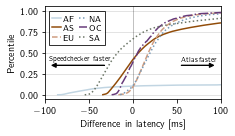

In [12]:
results_sc = get_lowest_avg_ping_unfiltered_geo("tcp", country=False, glob=True)
results_ripe = get_lowest_avg_ping_unfiltered_geo_ripe("tcp", country=False, glob=True)
results_diff = {}

# calculate means of the differences between every measurement from Speedchecker and every measurement
# from RIPE Atlas towards the closest datacenter on the same continent
for cont in results_sc:
    results_diff[cont] = []
    for num in results_sc[cont]:
        tmp = []
        for num2 in results_ripe[cont]:
            tmp.append(num - num2)
        results_diff[cont].append(np.mean(tmp))
        
fig, ax = plt.subplots(figsize=(3.37,2))
ax.axvline(x=0, linewidth=0.8, color="black", linestyle="-", alpha=0.3)
for cont in sorted(results_diff.keys()):
    xs = np.sort(list(filter(lambda x: x < 400, results_diff[cont])))
    ys = np.arange(1, len(xs) + 1) / len(xs)
    indices = []
    current = xs[0]
    for i, x in enumerate(xs):
        if x != current:
            current = x
            indices.append(i - 1)
    indices.append(len(ys) - 1)
    xs = sorted(set(xs))
    ys = [ys[i] for i in indices]
    ax.plot(xs, ys, label=cont, color=continent_colors[cont], linestyle=lstyles[cont])
ax.set_xlabel("Difference in latency [ms]")
ax.set_ylabel("Percentile")
ax.set_xlim([-100,100])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

ax.text(-95, 0.4, "Speedchecker faster", fontsize="x-small")
ax.arrow(-32, 0.35, -55, 0, head_width=0.05, head_length=5, color="black")
ax.text(55, 0.4, "Atlas faster", fontsize="x-small")
ax.arrow(55, 0.35, 32, 0, head_width=0.05, head_length=5, color="black")
ax.legend(handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper left", fancybox=False, edgecolor="k", fontsize="small", ncol=2)

fig.tight_layout()
plt.savefig("Figs/Fig_5.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 6 - Intercontinental latency for Africa and South America

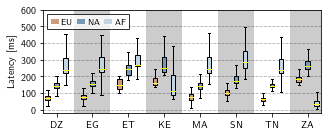

In [17]:
def adjust_box(plot):
    plt.setp(plot['boxes'][0], facecolor=continent_colors[target1], linewidth=1)
    plt.setp(plot['medians'][0], color='yellow')
    plt.setp(plot['boxes'][1], facecolor=continent_colors[target2], linewidth=1)
    plt.setp(plot['medians'][1], color='yellow')
    plt.setp(plot['boxes'][2], facecolor=continent_colors[cont], linewidth=1)
    plt.setp(plot['medians'][2], color='yellow')

cont = "AF"
target1, target2 = "EU", "NA"
countries = ["DZ", "EG", "ET", "KE", "MA", "SN", "TN", "ZA"]

results_inter1 = get_lowest_avg_ping_unfiltered_geo("tcp", continent=target1, source_continent=cont)

results_inter2 = get_lowest_avg_ping_unfiltered_geo("tcp", continent=target2, source_continent=cont)

results_intra = get_lowest_avg_ping_unfiltered_geo("tcp", continent=cont)

fig, ax = plt.subplots(figsize=(4.66, 2))
width = 0.5
for i, co in enumerate(countries):
    positions = np.arange(i * 4, i * 4 + 3)
    bp = ax.boxplot([results_inter1[co], results_inter2[co], results_intra[co]], positions=positions, 
                    widths=width, showfliers=False, patch_artist=True)
    adjust_box(bp)
    
xspan = 4
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(countries))
    if i % 2 == 1]
    
ax.set_xticks(np.arange(1, 1 + 4 * len(countries), 4))
ax.set_xticklabels(countries)
ax.set_xlim([-0.5, 4 * len(countries) - 1.5])
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0, 700, 100))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=continent_colors[target1]), Patch(facecolor=continent_colors[target2]),
           Patch(facecolor=continent_colors[cont])]
labels = [target1, target2, cont]

ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper left", fancybox=False, edgecolor="k", fontsize="small", ncol=3)
plt.grid(True, axis='y', linestyle='--')

fig.tight_layout()
plt.savefig("Figs/Fig_6a.pdf".format(cont), bbox_inches = "tight", pad_inches = 0)
plt.show()

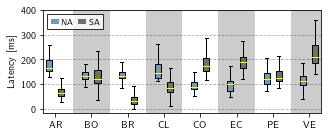

In [19]:
def adjust_box(plot):
    plt.setp(plot['boxes'][0], facecolor=continent_colors[target], linewidth=1)
    plt.setp(plot['medians'][0], color='yellow')
    plt.setp(plot['boxes'][1], facecolor=continent_colors[cont], linewidth=1)
    plt.setp(plot['medians'][1], color='yellow')

cont = "SA"
target = "NA"

results_inter = get_lowest_avg_ping_unfiltered_geo("tcp", continent=target, source_continent=cont)

results_intra = get_lowest_avg_ping_unfiltered_geo("tcp", continent=cont)

countries = sorted(results_inter.keys())

fig, ax = plt.subplots(figsize=(4.66, 2))
width = 0.5
for i, co in enumerate(countries):
    positions = np.arange(i * 3, i * 3 + 2)
    bp = ax.boxplot([results_inter[co], results_intra[co]], positions=positions, widths=width,
                   showfliers=False, patch_artist=True)
    adjust_box(bp)
    
xspan = 3
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(countries))
    if i % 2 == 1]

ax.set_xticks(np.arange(0.5, 0.5 + 3 * len(countries), 3))
ax.set_xticklabels(countries)
ax.set_xlim([-0.5, 3 * len(countries) - 1.5])
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0, 500, 100))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=continent_colors[target]), Patch(facecolor=continent_colors[cont])]
labels = [target, cont]

ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper left", fancybox=False, edgecolor="k", fontsize="small", ncol=3)
plt.grid(True, axis='y', linestyle='--')

fig.tight_layout()
plt.savefig("Figs/Fig_6b.pdf".format(cont), bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 7, 8, 9 & 17 - Last-mile latency analysis

## Data preparation (takes ~2 hours)

In [71]:
# Speedchecker

first_hop_latency = {}
home_ids = []
other_ids = []

tracert_ids_sql = """select TracerouteID from Hops where TracerouteID in (select TracerouteID from Traceroute T 
                  join Probes P on T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL 
                  where P.Continent = D.Continent) group by TracerouteID having count(*) > 2"""

tracert_latency_sql = """with ranked_hops as (
                      select HopNumber, TracerouteID, RTT1, RTT2, RTT3, row_number() over 
                      (partition by TracerouteID order by HopNumber desc) as rn from Hops where TracerouteID in {})
                      select TracerouteID, RTT1, RTT2, RTT3 from ranked_hops where rn = 1"""

hops_sql = """with ranked_hops as (
           select HopIP, HopNumber, TracerouteID, RTT1, RTT2, RTT3, row_number() over 
           (partition by TracerouteID order by HopNumber asc) as rn, ASN
           from Hops H join NodeInfo N on H.HopIP = N.IP where TracerouteID in {})
           select HopIP, TracerouteID, HopNumber, RTT1, RTT2, RTT3, rn, ASN from ranked_hops where rn in (1, 2)"""

cursor.execute(tracert_ids_sql) # get traceroute ids of paths with more than 2 identified hops
filtered_ids = tuple([r[0] for r in cursor])

cursor.execute(tracert_latency_sql.format(filtered_ids))
tracert_latencies = {}
for row in cursor:
    tracert_latencies[row[0]] = [x for x in row[1:] if x is not None and 0 < x < 1000]

cursor.execute(hops_sql.format(filtered_ids))
current_id = 0
skip = False
lat = ()
home_asns = []
other_asns = []
for row in cursor:
    h_ip = row[0]
    t_id = row[1]
    hn = row[2]
    rtts = [x for x in row[3:6] if x is not None and 0 < x < 1000]
    rn = row[6]  
    asn = row[7]
    if current_id != t_id:
        current_id = t_id
        skip = False
    if rn == 1:
        if is_private_ip(h_ip):
            lat = (rtts, )
        else:
            skip = True
            if len(rtts) > 0 and hn == 1:
                other_ids.append(t_id)
                other_asns.append(asn)
                first_hop_latency[t_id] = rtts
    elif not is_private_ip(h_ip) and not skip:
            lat += (rtts, )
            first_hop_latency[t_id] = lat
            home_ids.append(t_id)
            home_asns.append(asn)
                
sc_tracert_loc_sql = """select TracerouteID, P.Continent from Traceroute T join Probes P on 
                     T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL
                     where D.Continent = P.Continent"""

cursor.execute(sc_tracert_loc_sql)
relevant_ids_sc = {}
for t_id, co in cursor:
    if co not in relevant_ids_sc:
        relevant_ids_sc[co] = []
    relevant_ids_sc[co].append(t_id)
    
r_ids = tuple(home_ids + other_ids)
probe_tracert_sql = "select ProbeID, TracerouteID, DestinationURL from Traceroute where TracerouteID in {}"
cursor.execute(probe_tracert_sql.format(r_ids))

probe_lat_home = collections.defaultdict(lambda: collections.defaultdict(list))
tracert_id_home = collections.defaultdict(lambda: collections.defaultdict(list))
probe_lat_other = collections.defaultdict(lambda: collections.defaultdict(list))
tracert_id_other = collections.defaultdict(lambda: collections.defaultdict(list))
for p_id, t_id, url in cursor:
    if t_id in home_ids:
        probe_lat_home[p_id][url] += tracert_latencies[t_id]
        tracert_id_home[p_id][url].append(t_id)
    else:
        probe_lat_other[p_id][url] += tracert_latencies[t_id]
        tracert_id_other[p_id][url].append(t_id)
    
closest_ids_home = []
for probe_id in tracert_id_home:
    lowest = ()
    for dc in probe_lat_home[probe_id]:
        pings = probe_lat_home[probe_id][dc]
        if len(pings) > 0:
            avg = sum(pings)/len(pings)
            if lowest == ():
                lowest = (dc, avg)
            elif avg < lowest[1]:
                lowest = (dc, avg)
    if lowest != ():            
        closest_ids_home += tracert_id_home[probe_id][lowest[0]]
        
closest_ids_other = []
for probe_id in tracert_id_other:
    lowest = ()
    for dc in probe_lat_other[probe_id]:
        pings = probe_lat_other[probe_id][dc]
        if len(pings) > 0:
            avg = sum(pings)/len(pings)
            if lowest == ():
                lowest = (dc, avg)
            elif avg < lowest[1]:
                lowest = (dc, avg)
    if lowest != ():            
        closest_ids_other += tracert_id_other[probe_id][lowest[0]]

sc_tracert_loc_sql = """select TracerouteID, P.Continent from Traceroute T join Probes P on 
                     T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL
                     where D.Continent = P.Continent and TracerouteID in {}"""

cursor.execute(sc_tracert_loc_sql.format(tuple(closest_ids_home + closest_ids_other)))
relevant_ids_home = collections.defaultdict(list)
relevant_ids_other = collections.defaultdict(list)
for t_id, co in cursor:
    if t_id in closest_ids_home:
        relevant_ids_home[co].append(t_id)
    else:
        relevant_ids_other[co].append(t_id)
        
sc_per_home = collections.defaultdict(list)
sc_per_other = collections.defaultdict(list)

for co in relevant_ids_home:
    for t_id in relevant_ids_home[co]:
        home = first_hop_latency[t_id][0]
        isp = first_hop_latency[t_id][1]
        dst = tracert_latencies[t_id]
        if home and isp and dst:
            home = np.mean(home)
            isp = np.mean(isp)
            dst = np.mean(dst)
            sc_per_home[co].append(100*isp / dst)

for co in relevant_ids_other:
    for t_id in relevant_ids_other[co]:
        isp = first_hop_latency[t_id]
        dst = tracert_latencies[t_id]
        if isp and dst:
            isp = np.mean(isp)
            dst = np.mean(dst)
            sc_per_other[co].append(100*isp / dst)
    
# RIPE Atlas
            
first_hop_latency_ripe = {}

tracert_ids_sql = """select TI.ID from TracerouteInfo TI join Datacenter D on D.ID = TI.datacenter 
                  join Probes P on P.ID = TI.probe_id join Traceroute T on T.ID = TI.ID where
                  P.Continent = D.Continent and protocol = 'ICMP' and home = 1"""

tracert_latency_sql = """with ranked_hops AS ( 
                      SELECT Traceroute_ID, rtt_after, attempt, ROW_NUMBER() OVER  
                      (PARTITION BY Traceroute_ID, attempt ORDER BY hop_number DESC) AS rn FROM Hops  
                      WHERE Traceroute_ID IN {})
                      select Traceroute_ID, rtt_after, attempt from ranked_hops where rn = 1"""

hops_sql = """with ranked_hops as (
           select dst_ip, hop_number, Traceroute_ID, rtt_after, row_number() over 
           (partition by Traceroute_ID, attempt order by hop_number asc) as rn, ASN, attempt
           from Hops H join NodeInfo N on H.dst_ip = N.IP where Traceroute_ID in {})
           select dst_ip, Traceroute_ID, hop_number, rtt_after, rn, ASN, attempt from ranked_hops where rn = 1"""

cursor_ripe.execute(tracert_ids_sql)
filtered_ids_ripe = tuple([r[0] for r in cursor_ripe])

cursor_ripe.execute(tracert_latency_sql.format(filtered_ids_ripe))
tracert_latencies_ripe = {}
for t_id, rtt, att in cursor_ripe:
    if rtt is not None and 0 < rtt < 1000:
        tracert_latencies_ripe[(t_id, att)] = rtt

cursor_ripe.execute(hops_sql.format(filtered_ids_ripe))
current_id = -1
current_att = -1
skip = False
lat = ()
home_asns_ripe = []
for row in cursor_ripe:
    h_ip = row[0]
    t_id = row[1]
    hn = row[2]
    rtt = row[3]
    rn = row[4]  
    asn = row[5]
    att = row[6]    
    first_hop_latency_ripe[(t_id, att)] = rtt
    home_asns_ripe.append(asn)

ripe_tracert_loc_sql = """select T.ID, P.Continent from TracerouteInfo T join Probes P on T.probe_id = P.ID join 
                       Datacenter D on T.url = D.url join Traceroute TR on T.ID = TR.ID
                       where P.Continent = D.Continent
                       and protocol = 'ICMP' and home = 1"""

cursor_ripe.execute(ripe_tracert_loc_sql)
relevant_ids_ripe = {}
for t_id, co in cursor_ripe:
    if co not in relevant_ids_ripe:
        relevant_ids_ripe[co] = []
    relevant_ids_ripe[co].append(t_id)
    
# Calculations

sc_per = {}
sc_abs = {}
sc_other_per = {}
sc_other_abs = {}
sc_isp_per = {}
sc_isp_abs = {}
ripe_per = {}
ripe_abs = {}

for co in relevant_ids_sc:
    for t_id in relevant_ids_sc[co]:
        if t_id in home_ids:
            if co not in sc_abs:
                sc_per[co] = []
                sc_isp_per[co] = []
                sc_abs[co] = []
                sc_isp_abs[co] = []
            home = first_hop_latency[t_id][0]
            isp = first_hop_latency[t_id][1]
            dst = tracert_latencies[t_id]
            if home and isp and dst:
                home = np.mean(home)
                isp = np.mean(isp)
                dst = np.mean(dst)
                sc_per[co].append(100*isp / dst)
                sc_abs[co].append(isp)
                sc_isp_per[co].append(100*(isp - home) / dst)
                sc_isp_abs[co].append(isp - home)
        elif t_id in other_ids:
            if co not in sc_other_abs:
                sc_other_per[co] = []
                sc_other_abs[co] = []
            isp = first_hop_latency[t_id]
            dst = tracert_latencies[t_id]
            if isp and dst:
                isp = np.mean(isp)
                dst = np.mean(dst)
                sc_other_per[co].append(100*isp / dst)
                sc_other_abs[co].append(isp)
            
for co in relevant_ids_ripe:
    for t_id in relevant_ids_ripe[co]:
        if co not in ripe_abs:
            ripe_per[co] = []
            ripe_abs[co] = []
        for i in (0,1,2):
            tup = (t_id, i)
            if tup in first_hop_latency_ripe and tup in tracert_latencies_ripe:
                ripe_per[co].append(100*first_hop_latency_ripe[tup] / tracert_latencies_ripe[tup])
                ripe_abs[co].append(first_hop_latency_ripe[tup])

## Plotting

### Figure 7a - Percentage share of last mile latency compared to total latency grouped by continent for Speedchecker and RIPE Atlas

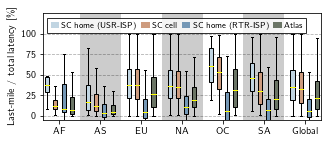

In [73]:
last_mile_home = [] # global percentages
last_mile_other = []
isp_per = []
last_mile_ripe = []
# filter out percentages >= 100
for co in sc_per:
    sc_per[co] = [x for x in sc_per[co] if x < 100]
    sc_other_per[co] = [x for x in sc_other_per[co] if x < 100]
    sc_isp_per[co] = [x for x in sc_isp_per[co] if x < 100] 
    last_mile_home += sc_per[co]
    last_mile_other += sc_other_per[co]
    isp_per += sc_isp_per[co]
for co in ripe_per:
    ripe_per[co] = [x for x in ripe_per[co] if x < 100]
    last_mile_ripe += ripe_per[co]

def adjust_box(plot):
    for i in range(4):
        plt.setp(plot['boxes'][i], facecolor=cols[i], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

fig, ax = plt.subplots(figsize=(4.66, 2))
for i, cont in enumerate(continents):
    width = 0.5
    positions = np.arange(i * 5, i * 5 + 4)
    bp = ax.boxplot([sc_per[cont], sc_other_per[cont], sc_isp_per[cont], ripe_per[cont]],
                    positions=positions, showfliers=False, patch_artist=True, widths=width)
    adjust_box(bp)
bp = ax.boxplot([last_mile_home, last_mile_other, isp_per, last_mile_ripe],
                positions=np.arange(len(continents) * 5, len(continents) * 5 + 4), showfliers=False,
                patch_artist=True, widths=width)
adjust_box(bp)

xspan = 5
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(continents) + 1)
    if i % 2 == 1]

ax.set_xticks(np.arange(1.5, 1.5 + 5 * (len(continents) + 1), 5))
ax.set_xticklabels(continents + ["Global"])
ax.set_ylabel("Last-mile / total latency [\%]")
ax.set_yticks(np.arange(0, 125, 25))
ax.set_ylim([-5,125])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=col) for col in cols[:4]]
labels = ["SC home (USR-ISP)", "SC cell", "SC home (RTR-ISP)", "Atlas"]

ax.legend(handles, labels, loc="upper left", fontsize="small", edgecolor="k", handlelength=1, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4)
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_7a.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

### Figure 7b - Absolute last-mile latency grouped by continent for Speedchecker and RIPE Atlas

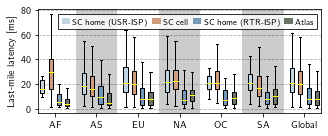

In [28]:
last_mile_home_abs = []
last_mile_other_abs = []
isp_abs = []
last_mile_ripe_abs = []
for co in sc_abs:
    sc_abs[co] = [x for x in sc_abs[co] if x < 100]
    sc_other_abs[co] = [x for x in sc_other_abs[co] if x < 100]
    sc_isp_abs[co] = [x for x in sc_isp_abs[co] if 0 < x < 100]
    last_mile_home_abs += sc_abs[co]
    last_mile_other_abs += sc_other_abs[co]
    isp_abs += sc_isp_abs[co]
for co in ripe_abs:
    ripe_abs[co] = [x for x in ripe_abs[co] if x < 100]
    last_mile_ripe_abs += ripe_abs[co]

def adjust_box(plot):
    for i in range(4):
        plt.setp(plot['boxes'][i], facecolor=cols[i], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

fig, ax = plt.subplots(figsize=(4.66, 2))
for i, cont in enumerate(continents):
    width = 0.5
    positions = np.arange(i * 5, i * 5 + 4)
    bp = ax.boxplot([sc_abs[cont], sc_other_abs[cont], sc_isp_abs[cont], ripe_abs[cont]], 
                     positions=positions, showfliers=False, patch_artist=True, widths=width)
    adjust_box(bp)
bp = ax.boxplot([last_mile_home_abs, last_mile_other_abs, isp_abs, last_mile_ripe_abs], 
                positions=np.arange(len(continents) * 5, len(continents) * 5 + 4), showfliers=False,
                patch_artist=True, widths=width)
adjust_box(bp)

xspan = 5
[ax.axvspan(i * 5 - 1, i * 5 - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(continents) + 1)
    if i % 2 == 1]

ax.set_xticks(np.arange(1.5, 1.5 + 5 * (len(continents) + 1), 5))
ax.set_xticklabels(continents + ["Global"])
ax.set_ylabel("Last-mile latency [ms]")
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=col) for col in cols[:4]]
labels = ["SC home (USR-ISP)", "SC cell", "SC home (RTR-ISP)", "Atlas"]

ax.legend(handles, labels, loc="upper right", fontsize="small", edgecolor="k", handlelength=1, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4)
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_7b.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

### Figure 8 - Coefficient of Variation for last-mile latency of all probes grouped by continent

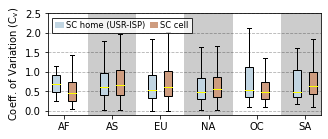

In [29]:
r_ids = tuple(home_ids + other_ids)
cursor.execute("""select Pr.ProbeID, TracerouteID, Pr.Continent from Traceroute T join Probes Pr on
               T.ProbeID = Pr.ProbeID where TracerouteID in {}""".format(r_ids))
probes_map = {}
probes_loc = {}
for p_id, t_id, cont in cursor:
    if p_id not in probes_map:
        probes_map[p_id] = []
    probes_map[p_id].append(t_id)
    probes_loc[p_id] = cont
    
probe_vars = {}
probe_env = {}
for p_id in probes_map:
    lats = []
    for t_id in probes_map[p_id]:
        if t_id in home_ids:
            lats += first_hop_latency[t_id][1]
            probe_env[p_id] = 0
        else:
            lats += first_hop_latency[t_id]
            probe_env[p_id] = 1
    probe_vars[p_id] = lats

vars_home = {cont: [] for cont in continents}
vars_other = {cont: [] for cont in continents}
for p_id in probe_vars:
    if len(probe_vars[p_id]) >= 5:
        if probe_env[p_id] == 0:
            vars_home[probes_loc[p_id]].append(stats.variation(probe_vars[p_id]))
        else:
            vars_other[probes_loc[p_id]].append(stats.variation(probe_vars[p_id]))

plt.rcParams.update({"text.usetex": False})
fig, ax = plt.subplots(figsize=(4.66, 2))
pos1 = np.arange(0, 3 * len(continents), 3)
pos2 = np.arange(1, 3 * len(continents) + 1, 3)
ax.boxplot([vars_home[cont] for cont in continents], positions=pos1, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[0], lw=1), medianprops=dict(color="yellow"))
ax.boxplot([vars_other[cont] for cont in continents], positions=pos2, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[1], lw=1), medianprops=dict(color="yellow"))
ax.set_xticks(np.arange(0.5, 3 * len(continents), 3))
ax.set_xticklabels(continents)
ax.set_ylabel("Coeff. of Variation ($\mathregular{C_v}$)")
ax.set_yticks(np.arange(0, 3, 0.5))
ax.set_ylim([-0.1, 2.5])
ax.set_xlim([-0.5, 3 * len(continents) - 1.5])

xspan = 3
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(continents) + 1)
    if i % 2 == 1]

handles = [Patch(facecolor=cols[0]), Patch(facecolor=cols[1])]
labels = ["SC home (USR-ISP)", "SC cell"]

ax.legend(handles, labels, loc="upper left", fontsize="small", edgecolor="k", handlelength=1, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4)
plt.grid(True, axis="y", linestyle="--")

plt.savefig("Figs/Fig_8.pdf", bbox_inches="tight", pad_inches=0)
plt.show()
plt.rcParams.update({"text.usetex": True})

### Figure 9 - Coefficient of variation of all probes in two countries per continent

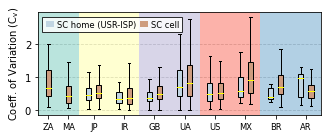

In [30]:
countries = ("ZA", "MA", "JP", "IR", "GB", "UA", "US", "MX", "BR", "AR")
r_ids = tuple(home_ids + other_ids)
cursor.execute("""select Pr.ProbeID, TracerouteID, Pr.Country from Traceroute T join Probes Pr on
               T.ProbeID = Pr.ProbeID where TracerouteID in {} and Pr.Country in {}""".format(r_ids, countries))
probes_map = {}
probes_loc = {}
for p_id, t_id, co in cursor:
    if p_id not in probes_map:
        probes_map[p_id] = []
    probes_map[p_id].append(t_id)
    probes_loc[p_id] = co
    
probe_vars = {}
probe_env = {}
for p_id in probes_map:
    lats = []
    for t_id in probes_map[p_id]:
        if t_id in home_ids:
            lats += first_hop_latency[t_id][1]
            probe_env[p_id] = 0
        else:
            lats += first_hop_latency[t_id]
            probe_env[p_id] = 1
    probe_vars[p_id] = lats

vars_home = collections.defaultdict(list)
vars_other = collections.defaultdict(list)
for p_id in probe_vars:
    if len(probe_vars[p_id]) >= 5:
        if probe_env[p_id] == 0:
            vars_home[probes_loc[p_id]].append(stats.variation(probe_vars[p_id]))
        else:
            vars_other[probes_loc[p_id]].append(stats.variation(probe_vars[p_id]))
            
def adjust_box(plot, index, t):
    plt.setp(plot['boxes'][index], facecolor=type_colors[t], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

type_colors = {0: cols[0], 1: cols[1]}

plt.rcParams.update({"text.usetex": False})
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for co in countries:
    ts = []
    data = []
    if len(vars_home[co]) >= 5:
        ts.append(0)
        data.append(vars_home[co])
    if len(vars_other[co]) >= 5:
        ts.append(1)    
        data.append(vars_other[co])
    positions = np.arange(counter, counter + len(ts))
    bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
    for i, t in enumerate(ts):
        adjust_box(bp, i, t)
    tick_pos.append((counter + counter + len(ts) - 1)/2)
    counter += len(ts) + 1
    
ax.set_xticks(tick_pos)
ax.set_xticklabels(countries, fontsize="small")
ax.set_ylabel("Coeff. of Variation ($\mathregular{C_v}$)")

ax.axvspan(-1, 3, facecolor="#8dd3c7", alpha=0.6)
ax.axvspan(3, 9, facecolor="#ffffb3", alpha=0.6)
ax.axvspan(9, 15, facecolor="#bebada", alpha=0.6)
ax.axvspan(15, 21, facecolor="#fb8072", alpha=0.6)
ax.axvspan(21, 27, facecolor="#80b1d3", alpha=0.6)

ax.set_xlim([-1, 27])

legend_keys = []
legend_labels = ["SC home (USR-ISP)", "SC cell"]
for t in type_colors:
    legend_keys.append(Patch(facecolor = type_colors[t]))

ax.legend(legend_keys, legend_labels, loc="upper left",
           ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, fontsize="small")
plt.grid(True, axis="y", linestyle="--")

plt.savefig("Figs/Fig_9.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()
plt.rcParams.update({"text.usetex": True})

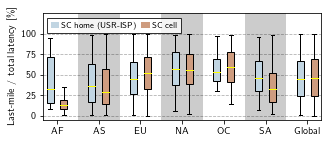

In [32]:
total_home = []
total_other = []
for co in sc_per_home:
    sc_per_home[co] = [x for x in sc_per_home[co] if x < 100]
    sc_per_other[co] = [x for x in sc_per_other[co] if x < 100]
    total_home += sc_per_home[co]
    total_other += sc_per_other[co]

def adjust_box(plot):
    for i in (0, 1):
        plt.setp(plot['boxes'][i], facecolor=cols[i], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

fig, ax = plt.subplots(figsize=(4.66, 2))
for i, cont in enumerate(continents):
    width = 0.5
    positions = np.arange(i * 3, i * 3 + 2)
    bp = ax.boxplot([sc_per_home[cont], sc_per_other[cont]],
                    positions=positions, showfliers=False, patch_artist=True, widths=width)
    adjust_box(bp)
bp = ax.boxplot([total_home, total_other], 
                positions=np.arange(len(continents) * 3, len(continents) * 3 + 2), showfliers=False,
                patch_artist=True, widths=width)
adjust_box(bp)

xspan = 3
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(continents) + 1)
    if i % 2 == 1]

ax.set_xticks(np.arange(0.5, 0.5 + 3 * (len(continents) + 1), 3))
ax.set_xticklabels(continents + ["Global"])
ax.set_ylabel("Last-mile / total latency [\%]")
ax.set_yticks(np.arange(0, 125, 25))
ax.set_ylim([-5,125])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=col) for col in cols[:4]]
labels = ["SC home (USR-ISP)", "SC cell"]

ax.legend(handles, labels, loc="upper left", fontsize="small", edgecolor="k", handlelength=1, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4)
plt.grid(True, axis="y", linestyle="--")

plt.savefig("Figs/Fig_17.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 10 - AS-level path lengths for the different cloud providers

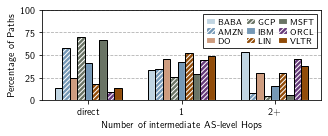

In [36]:
def adjust_box(plot, index, cont):
    plt.setp(plot["boxes"][index], facecolor=continent_colors[cont], linewidth=1)
    plt.setp(plot["medians"][index], color="black")

provider_abbrev = {"Alibaba": "BABA", "Amazon EC2": "AMZN", 
                   "DigitalOcean": "DO", "Google": "GCP", "IBM": "IBM", "Linode": "LIN", 
                   "Microsoft": "MSFT", "Oracle": "ORCL", "Vultr": "VLTR"}

as_hops_sql = """with id_info as (select TracerouteID, Provider, D.Continent from Traceroute T join Datacenters D on 
              T.DestinationURL = D.URL join Probes P on T.ProbeID = P.ProbeID where P.Continent = D.Continent),
              t_start as (select ASN, TracerouteID from Traceroute T join Probes P on T.ProbeID = P.ProbeID
              where TracerouteID in (select TracerouteID from id_info)),
              t_hops as (select N.ASN, H.TracerouteID from Hops H join 
              NodeInfo N on H.HopIP = N.IP where H.TracerouteID in (select TracerouteID from id_info) and N.ASN != -1),
              t_complete as (select * from t_start union all select * from t_hops)
              select Provider, count(distinct ASN) as cnt from t_complete T join id_info I on 
              T.TracerouteID = I.TracerouteID group by T.TracerouteID having cnt > 1"""
cursor.execute(as_hops_sql)
as_counts = {}
for prov, num in cursor:
    if prov != "Amazon Lightsail":
        if prov not in as_counts:
            as_counts[prov] = []
        as_counts[prov].append(num)

target_providers = sorted(provider_abbrev.keys())
results = {}
for prov in target_providers:
    total = len(as_counts[prov])
    zero_as = (as_counts[prov].count(2)  *100) / total
    one_as = (as_counts[prov].count(3) * 100) / total
    more_as = 100 - zero_as - one_as
    results[prov] = [zero_as, one_as, more_as]    

fig, ax = plt.subplots(figsize=(4.66, 2))
labels = ["direct", "1", "2+"]
x = np.arange(len(labels))
width = 0.08
pos=np.arange(-4, 5, 1)

for i in range(len(target_providers)):
    index = i//2 if i%2 == 0 else (i//2 + 2) % len(target_providers)
    ax.bar(x + pos[i]*width, results[target_providers[i]], width, color=cols[index],
           label=provider_abbrev[target_providers[i]],
           edgecolor="white", linewidth=0.1, zorder=1, hatch="/////" if i%2 == 1 else "")
    ax.bar(x + pos[i]*width, results[target_providers[i]], width, color="none",
           edgecolor="k", linewidth=1, zorder=2)

ax.set_ylabel("Percentage of Paths")
ax.set_ylim(0, 100)
ax.set_xlabel("Number of intermediate AS-level Hops")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False
ax.legend(loc="upper right", fontsize="small", edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=3)
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_10.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 11 - Pervasiveness for the different cloud providers grouped by continent

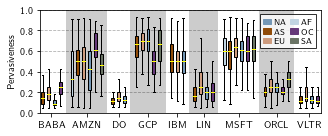

In [37]:
def adjust_box(plot, index, cont):
    plt.setp(plot['boxes'][index], facecolor=continent_colors[cont], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

cloud_count_sql = "with id_prov as (select TracerouteID, Provider, Continent from Traceroute T join Datacenters D " \
                  "on T.DestinationURL = D.URL)" \
                  "select count(case when ASN in {} then 1 end) as cnt, count(*), Provider, I.Continent " \
                  "from Hops H join NodeInfo N on H.HopIP = N.IP join id_prov I on H.TracerouteID = I.TracerouteID " \
                  "where H.TracerouteID in (select TracerouteID from Traceroute T join Datacenters D " \
                  "on T.DestinationURL = D.URL) group by H.TracerouteID having cnt > 0"
cloud_counts_per = {}
cursor.execute(cloud_count_sql.format(tuple(asns)))
for cloud, total, prov, cont in cursor:
    if prov != "Amazon Lightsail":
        if prov not in cloud_counts_per:
            cloud_counts_per[prov] = {}
        if cont not in cloud_counts_per[prov]:
            cloud_counts_per[prov][cont] = []
        if total > 2:
            cloud_counts_per[prov][cont].append(cloud/total)
            
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for prov in sorted(cloud_counts_per.keys()):
    conts = sorted(cloud_counts_per[prov].keys())
    data = [[y for y in cloud_counts_per[prov][x] if 0 < y < 1] for x in conts]
    positions = np.arange(counter, counter + len(conts))
    bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
    for i in range(len(conts)):
        adjust_box(bp, i, conts[i])
    tick_pos.append((counter + counter + len(conts) - 1)/2)
    counter += len(conts) + 1
    
ax.set_xticks(tick_pos)
ax.set_xticklabels(provider_abbrev[x] for x in sorted(cloud_counts_per.keys()))
ax.set_ylim([0, 1])
ax.set_ylabel("Pervasiveness")

ax.axvspan(4, 11, facecolor="k", alpha=0.2)
ax.axvspan(15, 21, facecolor="k", alpha=0.2)
ax.axvspan(25, 30, facecolor="k", alpha=0.2)
ax.axvspan(37, 43, facecolor="k", alpha=0.2)

plt.grid(True, axis='y', linestyle='--')

legend_elements = []
for cont in continent_colors:
    legend_elements.append(Patch(color=continent_colors[cont], label=cont))

ax.legend(handles=legend_elements, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper right", fancybox=False, edgecolor="k", fontsize="small", ncol=2)
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

plt.savefig("Figs/Fig_11.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 12, 13, 18 & 19 - Country-specific routing analysis

## Data preparation - Run before each figure with adjusted country and continent

In [62]:
country = "DE" # change target country (using 2-letter ISO code, e.g. JP for Japan or UA for Ukraine)
continent = "EU" # update continent accordingly (also 2-letter code)

tracert_ids_sql = "select TracerouteID from Hops where TracerouteID in (select TracerouteID from Traceroute T " \
                  "join Probes P on T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL " \
                  "where P.Country = ? and D.Continent = ?) group by TracerouteID having count(*) > 2"

tracert_no_ixp_sql = "with t_start as (select ASN, TracerouteID, 0 as HopNumber, 0 as IsIXP from Traceroute " \
                     "T join Probes P on T.ProbeID = P.ProbeID where TracerouteID in {})," \
                     "t_hops as (select N.ASN, H.TracerouteID, HopNumber, IsIXP from Hops H join " \
                     "NodeInfo N on H.HopIP = N.IP where TracerouteID in {})," \
                     "t_complete as (select * from t_start union all select * from t_hops)," \
                     "complete_ids as (select TracerouteID from t_complete group by TracerouteID having " \
                     "count(case when IsIXP = 1 then 1 end) = 0)" \
                     "select * from t_complete where TracerouteID in complete_ids order by TracerouteID"

tracert_ixp_sql = "with t_start as (select ASN, TracerouteID, 0 as HopNumber, 0 as IsIXP from Traceroute " \
                  "T join Probes P on T.ProbeID = P.ProbeID where TracerouteID in {})," \
                  "t_hops as (select N.ASN, H.TracerouteID, HopNumber, IsIXP from Hops H join " \
                  "NodeInfo N on H.HopIP = N.IP where TracerouteID in {})" \
                  "select * from t_start union all select * from t_hops order by TracerouteID"

cursor.execute(tracert_ids_sql, (country, continent))
filtered_ids = tuple([r[0] for r in cursor])

paths_no_ixp = {}
cursor.execute(tracert_no_ixp_sql.format(filtered_ids, filtered_ids))
for row in cursor:
    asn = row[0]
    t_id = row[1]
    if row[2] == 0 and asn != -1:
        paths_no_ixp[t_id] = (asn, )
    else:
        try:
            if (paths_no_ixp[t_id])[-1] != asn and asn != -1:
                paths_no_ixp[t_id] += (asn, )
        except KeyError:
            continue
result_no_ixp = [paths_no_ixp[k] for k in paths_no_ixp]
count_no_ixp = Counter(result_no_ixp)
result_no_ixp = list(set([x for x in result_no_ixp]))
    
paths_ixp = {}
cursor.execute(tracert_ixp_sql.format(filtered_ids, filtered_ids))
for row in cursor:
    asn = row[0]
    t_id = row[1]
    if row[2] == 0 and asn != -1:
        paths_ixp[t_id] = (asn, )
    else:
        try:
            if (paths_ixp[t_id])[-1] != asn and asn != -1:
                paths_ixp[t_id] += (asn, )
        except KeyError:
            continue
tracert_ixp_ids = [k for k in paths_ixp if k not in paths_no_ixp]
result_ixp = [(paths_ixp[k], 1) if k in tracert_ixp_ids else (paths_ixp[k], 0) for k in paths_ixp]
count_ixp = Counter(result_ixp)
result_ixp = list(set([x for x in result_ixp]))

tracert_dest_sql = "select TracerouteID, Country from Traceroute T join Datacenters D on T.DestinationURL = D.URL " \
                   "where TracerouteID in {}"
tracert_latency_sql = "with ranked_hops as (" \
                      "select HopNumber, TracerouteID, RTT1, RTT2, RTT3, row_number() over " \
                      "(partition by TracerouteID order by HopNumber desc) as rn from Hops where TracerouteID in {})" \
                      "select TracerouteID, RTT1, RTT2, RTT3 from ranked_hops where rn = 1"
path_lengths_sql = "select TracerouteID, count(*) from Hops where TracerouteID in {} group by TracerouteID"

cursor.execute(tracert_dest_sql.format(filtered_ids))
tracert_dest = {}
for t_id, cn in cursor:
    tracert_dest[t_id] = cn
    
cursor.execute(tracert_latency_sql.format(filtered_ids))
tracert_latencies = {}
for row in cursor:
    tracert_latencies[row[0]] = [x for x in row[1:] if x is not None and 0 < x < 1000]
    
cursor.execute(path_lengths_sql.format(filtered_ids))
path_lengths = {}
for t_id, num in cursor:
    path_lengths[t_id] = num

paths_filtered_ixp = {}
paths_filtered_ixp_counts = {}
for t_id in paths_ixp:
    first = paths_ixp[t_id][0]
    last = paths_ixp[t_id][-1]
    tup = (first, last)
    if get_pdb_info(first)[1] != "Content" and last in asns and None not in tup:
        tup = (tup, 1) if t_id in tracert_ixp_ids else (tup, 0)
        path = paths_ixp[t_id]
        if tup not in paths_filtered_ixp:
            paths_filtered_ixp[tup] = {}
        if path not in paths_filtered_ixp[tup]:
            paths_filtered_ixp[tup][path] = []
        paths_filtered_ixp[tup][path].append(t_id)
        if tup[0] not in paths_filtered_ixp_counts:
            paths_filtered_ixp_counts[tup[0]] = 0
        paths_filtered_ixp_counts[tup[0]] += 1

for tup in paths_filtered_ixp:
    for path in paths_filtered_ixp[tup]:
        paths_filtered_ixp[tup][path] = (round(len(paths_filtered_ixp[tup][path]) * 100 / 
                                               paths_filtered_ixp_counts[tup[0]], 3), paths_filtered_ixp[tup][path])

paths_sorted_ixp = {}
for tup in sorted(list(paths_filtered_ixp.keys()), key=lambda x: x[0]):
    sorted_keys = sorted(paths_filtered_ixp[tup], key=lambda x: paths_filtered_ixp[tup][x][0], reverse=True)
    paths_sorted_ixp[tup] = {}
    for path in sorted_keys:
        paths_sorted_ixp[tup][path] = paths_filtered_ixp[tup][path]

# Save traceroute data in csv in peering directory with more detailed information on intermediate ASs,
# destination countries, percentage shares of paths etc.

with open("peering/asn_path_map_" + country + ".csv", mode="w", encoding="utf-8") as f:
    f.write("source;intermediate;destination;with_ixp;percentage;total_paths;provider;avg_path_length;" \
            "avg_latency;destination_countries;ids\n")
    for tup in paths_sorted_ixp:
        for path in paths_sorted_ixp[tup]:
            src = (str(path[0]) + ": " + get_pdb_info(path[0])[0])
            dest = (str(path[-1]) + ": " + get_pdb_info(path[-1])[0])
            ixp = tup[1]
            per, ids = paths_sorted_ixp[tup][path]
            total_num = paths_filtered_ixp_counts[tup[0]]
            p_len = round(np.mean([path_lengths[x] for x in ids]), 2)
            dest_counts = Counter(list(map(lambda x: tracert_dest[x], ids))).most_common()
            dest_counts = list(map(str, dest_counts))
            latency_dict = {}
            for t_id in ids:
                cn = tracert_dest[t_id]
                if cn not in latency_dict:
                    latency_dict[cn] = []
                latency_dict[cn] += tracert_latencies[t_id]
            latency = [(dst, round(np.mean(latency_dict[dst]), 3)) if len(latency_dict[dst]) != 0 
                          else (dst, -1) for dst in latency_dict]
            latency = list(map(str, sorted(latency, key=lambda x: x[1])))
            if len(path) == 2:
                imd = " "
            else:
                imd = ", ".join(tuple(map(lambda x: "(" + str(x) + ": " + get_pdb_info(x)[0] + ")", \
                                    path[1:-1])))
            f.write(src + ";" + imd + ";" + dest + ";" + str(ixp) + ";" + str(per) + ";" + str(total_num) + ";" 
                    + asns_dict[path[-1]] + ";" + str(p_len) + ";" + ",".join(latency) + ";" 
                    + ",".join(dest_counts) + ";" + str(ids) + "\n")

## Plotting

### Figure 12 - Run Data preparation cell with "DE" as country and "EU" as continent

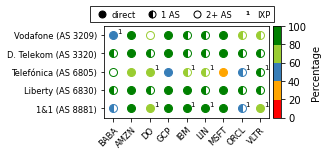

In [43]:
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})
plt.rcParams.update({"text.usetex": False})

df_ixp = pd.read_csv("peering/asn_path_map_" + country + ".csv", delimiter=";", 
                     converters={"intermediate": lambda x: x.split(",") if len(x) > 1 else ""})
occurence_df_ixp = df_ixp.groupby("source")[["total_paths"]].sum().reset_index()

# filter out likely erroneous paths and group them up
df_ixp = df_ixp[(df_ixp["total_paths"] > 20) & (df_ixp["percentage"] > 5)]
df_ixp["intermediate"] = df_ixp["intermediate"].apply(lambda x: len(x))
group_funcs = {"percentage": sum, "destination_countries": ",".join, "total_paths": max, "ids": ",".join}
df_ixp_grouped = df_ixp.groupby(["source", "intermediate", "destination", "with_ixp", "provider"]).agg(group_funcs).reset_index()
df_ixp_max = df_ixp_grouped.sort_values("percentage", ascending=False).drop_duplicates(["source", "destination"]).sort_index()
isps = ["3209", "3320", "6805", "6830", "8881"]
providers = list(map(str, sorted(list(asns_dict.keys()), key=lambda x: asns_dict[x])))
result = {}
path_type = {}
ixp_dict = {}
num_paths = {}
for row in df_ixp_max.itertuples(index=False):
    tup = (row.source.split(":")[0], row.destination.split(":")[0])
    result[tup] = row.percentage
    ixp_dict[tup] = row.with_ixp
    num_paths[tup] = row.total_paths
    if row.intermediate >= 2:
        path_type[tup] = 2
    else:
        path_type[tup] = row.intermediate
            
hmap_list = []
hmap_types = []
table_list = []
for isp in isps:
    res_list = []
    res_types = []
    num_path_list = []
    for provider in providers:
        tup = (isp, provider)
        if tup in result:
            num_path_list.append(num_paths[tup])
            res_list.append(result[tup])
            if ixp_dict[tup] == 0:
                res_types.append(path_type[tup])
            else:
                res_types.append(path_type[tup] + 10)
        else:
            num_path_list.append(0)
            res_list.append(0)
            res_types.append(-1)
    hmap_list.append(res_list)
    hmap_types.append(res_types)
    table_list.append(num_path_list)

fig, ax1 = plt.subplots(figsize=(4.66, 3))
hmap_cols = ["red", "orange", "#377eb8", "yellowgreen", "green"]
cmap = colors.ListedColormap(hmap_cols)
heatmap = ax1.imshow(hmap_list, cmap=cmap, alpha=0, vmin=100, vmax=500)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.arange(0, 120, 20)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, boundaries=bounds, ticks=bounds, orientation="vertical")
cb.set_label("Percentage")

isp_dict = {"3209": "Vodafone", "3320": "D. Telekom", "6805": "Telefónica", "6830": "Liberty",
           "8881": "1&1"}
isp_labels = ["{} (AS {})".format(isp_dict[asn], asn) for asn in isp_dict]
provider_labels = [asns_dict[x] for x in list(map(int,providers))]
provider_labels = [provider_abbrev[x] for x in provider_labels]
ax1.set_xticks(np.arange(len(providers)))
ax1.set_yticks(np.arange(len(isps)))
ax1.set_xticklabels(provider_labels, fontsize="small")
ax1.set_yticklabels(isp_labels, fontsize="small")

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(isps)):
    for j in range(len(providers)):
        if hmap_types[i][j] == -1:
            ax1.text(j, i, "-", ha="center", va="center", color="black", fontsize=15)
        else:
            if hmap_types[i][j] == 0 or hmap_types[i][j] == 10:
                fill = "full"
            elif hmap_types[i][j] == 1 or hmap_types[i][j] == 11:
                fill = "left"
            else:
                fill = "none"
            ax1.plot(j, i, fillstyle=fill, markerfacecoloralt="white",
                    marker="o", markerfacecolor=hmap_cols[int(hmap_list[i][j]) // 20], markersize=8, color="w",
                    markeredgecolor=hmap_cols[int(hmap_list[i][j]) // 20])
            if hmap_types[i][j] >= 10:
                ax1.annotate("$\mathregular{^1}$", xy = (j + 0.2, i + 0.05))

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=7, 
                  markeredgecolor="black"),
           Line2D([0], [0], fillstyle="left", marker="o", color="w", markerfacecolor="black", 
                  markerfacecoloralt="white", markersize=7, markeredgecolor="black"),
           Line2D([0], [0], marker="o", color="w", markerfacecolor="none", 
                  markeredgecolor="black", markersize=7),
           "$\mathregular{^1}$"]
labels = ["direct", "1 AS", "2+ AS", "IXP"]

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.28, 0.73, 1., .102), loc="lower left",
           ncol=5, borderaxespad=0., edgecolor="black", handletextpad=0.1, fontsize="small", fancybox=False,
           columnspacing=1)
fig.tight_layout()
plt.savefig("Figs/Fig_12a.pdf", bbox_inches="tight")
plt.show()
plt.rcParams.update({"text.usetex": True})

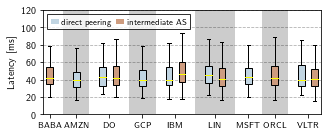

In [47]:
country = "DE"
target_country = "GB"

def adjust_box(plot, index, pt):
    plt.setp(plot['boxes'][index], facecolor=type_colors[pt], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

type_colors = {0: cols[0], 1: cols[1]}
latencies = {}

for row in df_ixp_max.itertuples(index=False):
        src = row.source.split(":")[0]
        prov = row.provider
        ids = [y for x in eval(row.ids) for y in x] if type(eval(row.ids)) == tuple else eval(row.ids)
        lats = [y for x in ids for y in tracert_latencies[x] if tracert_dest[x] == target_country]
        if prov not in latencies:
            latencies[prov] = {}
        pt = 0 if row.intermediate == 0 else 1
        if pt not in latencies[prov]:
            latencies[prov][pt] = []
        latencies[prov][pt] += lats
        
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for prov in sorted(latencies.keys()):
    pts = list(filter(lambda x: len(latencies[prov][x]) > 10, sorted(latencies[prov].keys())))
    data = [latencies[prov][x] for x in pts]
    positions = np.arange(counter, counter + len(pts))
    if len(data) > 0:
        bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
        for i, pt in enumerate(pts):
            adjust_box(bp, i, pt)
        tick_pos.append((counter + counter + len(pts) - 1)/2)
        counter += len(pts) + 1
    else:
        del latencies[prov]
    
ax.set_xticks(tick_pos)
ax.set_xticklabels([provider_abbrev[x] for x in sorted(latencies.keys())], fontsize="small")
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0,140,20))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.axvspan(1, 3, facecolor="k", alpha=0.2)
ax.axvspan(6, 8, facecolor="k", alpha=0.2)
ax.axvspan(11, 14, facecolor="k", alpha=0.2)
ax.axvspan(16, 18, facecolor="k", alpha=0.2)

legend_keys = []
legend_labels = ["direct peering", "intermediate AS"]
for pt in type_colors:
    legend_keys.append(Patch(facecolor = type_colors[pt]))

ax.legend(legend_keys, legend_labels, loc="upper left",
           ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, fontsize="small")
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_12b.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

### Figure 13 - Run Data preparation cell with "JP" as country and "AS" as continent

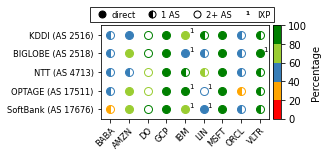

In [50]:
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})
plt.rcParams.update({"text.usetex": False})

df_ixp = pd.read_csv("peering/asn_path_map_" + country + ".csv", delimiter=";", 
                     converters={"intermediate": lambda x: x.split(",") if len(x) > 1 else ""})
occurence_df_ixp = df_ixp.groupby("source")[["total_paths"]].sum().reset_index()

df_ixp = df_ixp[(df_ixp["total_paths"] > 20) & (df_ixp["percentage"] > 5)]
df_ixp["intermediate"] = df_ixp["intermediate"].apply(lambda x: len(x))
group_funcs = {"percentage": sum, "destination_countries": ",".join, "total_paths": max, "ids": ",".join}
df_ixp_grouped = df_ixp.groupby(["source", "intermediate", "destination", "with_ixp", "provider"]).agg(group_funcs).reset_index()
df_ixp_max = df_ixp_grouped.sort_values("percentage", ascending=False).drop_duplicates(["source", "destination"]).sort_index()
isps = ["2516", "2518", "4713", "17511", "17676"]
providers = list(map(str, sorted(list(asns_dict.keys()), key=lambda x: asns_dict[x])))
result = {}
path_type = {}
ixp_dict = {}
num_paths = {}
for row in df_ixp_max.itertuples(index=False):
    tup = (row.source.split(":")[0], row.destination.split(":")[0])
    result[tup] = row.percentage
    ixp_dict[tup] = row.with_ixp
    num_paths[tup] = row.total_paths
    if row.intermediate >= 2:
        path_type[tup] = 2
    else:
        path_type[tup] = row.intermediate
            
hmap_list = []
hmap_types = []
table_list = []
for isp in isps:
    res_list = []
    res_types = []
    num_path_list = []
    for provider in providers:
        tup = (isp, provider)
        if tup in result:
            num_path_list.append(num_paths[tup])
            res_list.append(result[tup])
            if ixp_dict[tup] == 0:
                res_types.append(path_type[tup])
            else:
                res_types.append(path_type[tup] + 10)
        else:
            num_path_list.append(0)
            res_list.append(0)
            res_types.append(-1)
    hmap_list.append(res_list)
    hmap_types.append(res_types)
    table_list.append(num_path_list)

fig, ax1 = plt.subplots(figsize=(4.66, 3))
hmap_cols = ["red", "orange", "#377eb8", "yellowgreen", "green"]
cmap = colors.ListedColormap(hmap_cols)
heatmap = ax1.imshow(hmap_list, cmap=cmap, alpha=0, vmin=100, vmax=500)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.arange(0, 120, 20)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, boundaries=bounds, ticks=bounds, orientation="vertical")
cb.set_label("Percentage")

isp_dict = {"2516": "KDDI", "2518": "BIGLOBE", "4713": "NTT", "17511": "OPTAGE",
           "17676": "SoftBank"}
isp_labels = ["{} (AS {})".format(isp_dict[asn], asn) for asn in isp_dict]
provider_labels = [asns_dict[x] for x in list(map(int,providers))]
provider_labels = [provider_abbrev[x] for x in provider_labels]
ax1.set_xticks(np.arange(len(providers)))
ax1.set_yticks(np.arange(len(isps)))
ax1.set_xticklabels(provider_labels, fontsize="small")
ax1.set_yticklabels(isp_labels, fontsize="small")

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(isps)):
    for j in range(len(providers)):
        if hmap_types[i][j] == -1:
            ax1.text(j, i, "-", ha="center", va="center", color="black", fontsize=15)
        else:
            if hmap_types[i][j] == 0 or hmap_types[i][j] == 10:
                fill = "full"
            elif hmap_types[i][j] == 1 or hmap_types[i][j] == 11:
                fill = "left"
            else:
                fill = "none"
            ax1.plot(j, i, fillstyle=fill, markerfacecoloralt="white",
                    marker="o", markerfacecolor=hmap_cols[int(hmap_list[i][j]) // 20], markersize=8, color="w",
                    markeredgecolor=hmap_cols[int(hmap_list[i][j]) // 20])
            if hmap_types[i][j] >= 10:
                ax1.annotate("$\mathregular{^1}$", xy = (j + 0.2, i + 0.05))

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=7, 
                  markeredgecolor="black"),
           Line2D([0], [0], fillstyle="left", marker="o", color="w", markerfacecolor="black", 
                  markerfacecoloralt="white", markersize=7, markeredgecolor="black"),
           Line2D([0], [0], marker="o", color="w", markerfacecolor="none", 
                  markeredgecolor="black", markersize=7),
           "$\mathregular{^1}$"]
labels = ["direct", "1 AS", "2+ AS", "IXP"]

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.28, 0.73, 1., .102), loc="lower left",
           ncol=5, borderaxespad=0., edgecolor="black", handletextpad=0.1, fontsize="small", fancybox=False,
           columnspacing=1)
fig.tight_layout()
plt.savefig("Figs/Fig_13a.pdf", bbox_inches="tight")
plt.show()
plt.rcParams.update({"text.usetex": True})

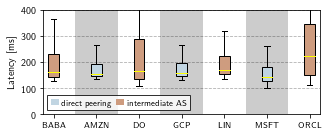

In [54]:
country = "JP"
target_country = "IN"

def adjust_box(plot, index, pt):
    plt.setp(plot['boxes'][index], facecolor=type_colors[pt], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

type_colors = {0: cols[0], 1: cols[1]}
latencies = {}

for row in df_ixp_max.itertuples(index=False):
        src = row.source.split(":")[0]
        prov = row.provider
        ids = [y for x in eval(row.ids) for y in x] if type(eval(row.ids)) == tuple else eval(row.ids)
        lats = [y for x in ids for y in tracert_latencies[x] if tracert_dest[x] == target_country]
        if prov not in latencies:
            latencies[prov] = {}
        pt = 0 if row.intermediate == 0 else 1
        if pt not in latencies[prov]:
            latencies[prov][pt] = []
        latencies[prov][pt] += lats
        
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for prov in sorted(latencies.keys()):
    pts = list(filter(lambda x: len(latencies[prov][x]) > 10, sorted(latencies[prov].keys())))
    data = [latencies[prov][x] for x in pts]
    positions = np.arange(counter, counter + len(pts))
    if len(data) > 0:
        bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
        for i, pt in enumerate(pts):
            adjust_box(bp, i, pt)
        tick_pos.append((counter + counter + len(pts) - 1)/2)
        counter += len(pts) + 1
    else:
        del latencies[prov]
    
ax.set_xticks(tick_pos)
ax.set_xticklabels([provider_abbrev[x] for x in sorted(latencies.keys())], fontsize="small")
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0,500,100))
ax.set_ylim([0, 400])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.axvspan(1, 3, facecolor="k", alpha=0.2)
ax.axvspan(5, 7, facecolor="k", alpha=0.2)
ax.axvspan(9, 11, facecolor="k", alpha=0.2)

legend_keys = []
legend_labels = ["direct peering", "intermediate AS"]
for pt in type_colors:
    legend_keys.append(Patch(facecolor = type_colors[pt]))

ax.legend(legend_keys, legend_labels, loc="lower left",
           ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, fontsize="small")
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_13b.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

### Figure 18 - Run Data preparation cell with "UA" as country and "EU" as continent

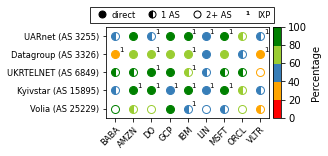

In [56]:
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})
plt.rcParams.update({"text.usetex": False})

df_ixp = pd.read_csv("peering/asn_path_map_" + country + ".csv", delimiter=";", 
                     converters={"intermediate": lambda x: x.split(",") if len(x) > 1 else ""})
occurence_df_ixp = df_ixp.groupby("source")[["total_paths"]].sum().reset_index()

df_ixp = df_ixp[(df_ixp["total_paths"] > 20) & (df_ixp["percentage"] > 5)]
df_ixp["intermediate"] = df_ixp["intermediate"].apply(lambda x: len(x))
group_funcs = {"percentage": sum, "destination_countries": ",".join, "total_paths": max, "ids": ",".join}
df_ixp_grouped = df_ixp.groupby(["source", "intermediate", "destination", "with_ixp", "provider"]).agg(group_funcs).reset_index()
df_ixp_max = df_ixp_grouped.sort_values("percentage", ascending=False).drop_duplicates(["source", "destination"]).sort_index()
isps = ["3255", "3326", "6849", "15895", "25229"]
providers = list(map(str, sorted(list(asns_dict.keys()), key=lambda x: asns_dict[x])))
result = {}
path_type = {}
ixp_dict = {}
num_paths = {}
for row in df_ixp_max.itertuples(index=False):
    tup = (row.source.split(":")[0], row.destination.split(":")[0])
    result[tup] = row.percentage
    ixp_dict[tup] = row.with_ixp
    num_paths[tup] = row.total_paths
    if row.intermediate >= 2:
        path_type[tup] = 2
    else:
        path_type[tup] = row.intermediate
            
hmap_list = []
hmap_types = []
table_list = []
for isp in isps:
    res_list = []
    res_types = []
    num_path_list = []
    for provider in providers:
        tup = (isp, provider)
        if tup in result:
            num_path_list.append(num_paths[tup])
            res_list.append(result[tup])
            if ixp_dict[tup] == 0:
                res_types.append(path_type[tup])
            else:
                res_types.append(path_type[tup] + 10)
        else:
            num_path_list.append(0)
            res_list.append(0)
            res_types.append(-1)
    hmap_list.append(res_list)
    hmap_types.append(res_types)
    table_list.append(num_path_list)

fig, ax1 = plt.subplots(figsize=(4.66, 3))
hmap_cols = ["red", "orange", "#377eb8", "yellowgreen", "green"]
cmap = colors.ListedColormap(hmap_cols)
heatmap = ax1.imshow(hmap_list, cmap=cmap, alpha=0, vmin=100, vmax=500)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.arange(0, 120, 20)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, boundaries=bounds, ticks=bounds, orientation="vertical")
cb.set_label("Percentage")

isp_dict = {"3255": "UARnet", "3326": "Datagroup", "6849": "UKRTELNET", "15895": "Kyivstar", 
            "25229": "Volia"}
isp_labels = ["{} (AS {})".format(isp_dict[asn], asn) for asn in isp_dict]
provider_labels = [asns_dict[x] for x in list(map(int,providers))]
provider_labels = [provider_abbrev[x] for x in provider_labels]
ax1.set_xticks(np.arange(len(providers)))
ax1.set_yticks(np.arange(len(isps)))
ax1.set_xticklabels(provider_labels, fontsize="small")
ax1.set_yticklabels(isp_labels, fontsize="small")

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(isps)):
    for j in range(len(providers)):
        if hmap_types[i][j] == -1:
            ax1.text(j, i, "-", ha="center", va="center", color="black", fontsize=15)
        else:
            if hmap_types[i][j] == 0 or hmap_types[i][j] == 10:
                fill = "full"
            elif hmap_types[i][j] == 1 or hmap_types[i][j] == 11:
                fill = "left"
            else:
                fill = "none"
            ax1.plot(j, i, fillstyle=fill, markerfacecoloralt="white",
                    marker="o", markerfacecolor=hmap_cols[int(hmap_list[i][j]) // 20], markersize=8, color="w",
                    markeredgecolor=hmap_cols[int(hmap_list[i][j]) // 20])
            if hmap_types[i][j] >= 10:
                ax1.annotate("$\mathregular{^1}$", xy = (j + 0.2, i + 0.05))

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=7, 
                  markeredgecolor="black"),
           Line2D([0], [0], fillstyle="left", marker="o", color="w", markerfacecolor="black", 
                  markerfacecoloralt="white", markersize=7, markeredgecolor="black"),
           Line2D([0], [0], marker="o", color="w", markerfacecolor="none", 
                  markeredgecolor="black", markersize=7),
           "$\mathregular{^1}$"]
labels = ["direct", "1 AS", "2+ AS", "IXP"]

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.28, 0.73, 1., .102), loc="lower left",
           ncol=5, borderaxespad=0., edgecolor="black", handletextpad=0.1, fontsize="small", fancybox=False,
           columnspacing=1)
fig.tight_layout()
plt.savefig("Figs/Fig_18a.pdf", bbox_inches="tight")
plt.show()
plt.rcParams.update({"text.usetex": True})

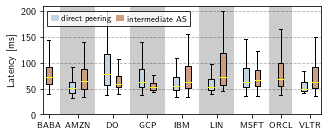

In [59]:
country = "UA"
target_country = "GB"

def adjust_box(plot, index, pt):
    plt.setp(plot['boxes'][index], facecolor=type_colors[pt], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

type_colors = {0: cols[0], 1: cols[1]}
latencies = {}

for row in df_ixp_max.itertuples(index=False):
        src = row.source.split(":")[0]
        prov = row.provider
        ids = [y for x in eval(row.ids) for y in x] if type(eval(row.ids)) == tuple else eval(row.ids)
        lats = [y for x in ids for y in tracert_latencies[x] if tracert_dest[x] == target_country]
        if prov not in latencies:
            latencies[prov] = {}
        pt = 0 if row.intermediate == 0 else 1
        if pt not in latencies[prov]:
            latencies[prov][pt] = []
        latencies[prov][pt] += lats
        
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for prov in sorted(latencies.keys()):
    pts = list(filter(lambda x: len(latencies[prov][x]) > 10, sorted(latencies[prov].keys())))
    data = [latencies[prov][x] for x in pts]
    positions = np.arange(counter, counter + len(pts))
    if len(data) > 0:
        bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
        for i, pt in enumerate(pts):
            adjust_box(bp, i, pt)
        tick_pos.append((counter + counter + len(pts) - 1)/2)
        counter += len(pts) + 1
    else:
        del latencies[prov]
    
ax.set_xticks(tick_pos)
ax.set_xticklabels([provider_abbrev[x] for x in sorted(latencies.keys())], fontsize="small")
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0,250,50))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.axvspan(1, 4, facecolor="k", alpha=0.2)
ax.axvspan(7, 10, facecolor="k", alpha=0.2)
ax.axvspan(13, 16, facecolor="k", alpha=0.2)
ax.axvspan(19, 21, facecolor="k", alpha=0.2)

legend_keys = []
legend_labels = ["direct peering", "intermediate AS"]
for pt in type_colors:
    legend_keys.append(Patch(facecolor = type_colors[pt]))

ax.legend(legend_keys, legend_labels, loc="upper left",
           ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, fontsize="small")
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_18b.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

### Figure 19 - Run Data preparation cell with changed country and continent again

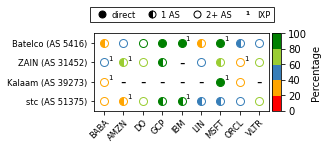

In [65]:
class TextHandlerB(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, text, fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerB()})
plt.rcParams.update({"text.usetex": False})

df_ixp = pd.read_csv("peering/asn_path_map_" + country + ".csv", delimiter=";", 
                     converters={"intermediate": lambda x: x.split(",") if len(x) > 1 else ""})
occurence_df_ixp = df_ixp.groupby("source")[["total_paths"]].sum().reset_index()

df_ixp = df_ixp[(df_ixp["total_paths"] > 20) & (df_ixp["percentage"] > 5)]
df_ixp["intermediate"] = df_ixp["intermediate"].apply(lambda x: len(x))
group_funcs = {"percentage": sum, "destination_countries": ",".join, "total_paths": max, "ids": ",".join}
df_ixp_grouped = df_ixp.groupby(["source", "intermediate", "destination", "with_ixp", "provider"]).agg(group_funcs).reset_index()
df_ixp_max = df_ixp_grouped.sort_values("percentage", ascending=False).drop_duplicates(["source", "destination"]).sort_index()
isps = ["5416", "31452", "39273", "51375"]
providers = list(map(str, sorted(list(asns_dict.keys()), key=lambda x: asns_dict[x])))
result = {}
path_type = {}
ixp_dict = {}
num_paths = {}
for row in df_ixp_max.itertuples(index=False):
    tup = (row.source.split(":")[0], row.destination.split(":")[0])
    result[tup] = row.percentage
    ixp_dict[tup] = row.with_ixp
    num_paths[tup] = row.total_paths
    if row.intermediate >= 2:
        path_type[tup] = 2
    else:
        path_type[tup] = row.intermediate
            
hmap_list = []
hmap_types = []
table_list = []
for isp in isps:
    res_list = []
    res_types = []
    num_path_list = []
    for provider in providers:
        tup = (isp, provider)
        if tup in result:
            num_path_list.append(num_paths[tup])
            res_list.append(result[tup])
            if ixp_dict[tup] == 0:
                res_types.append(path_type[tup])
            else:
                res_types.append(path_type[tup] + 10)
        else:
            num_path_list.append(0)
            res_list.append(0)
            res_types.append(-1)
    hmap_list.append(res_list)
    hmap_types.append(res_types)
    table_list.append(num_path_list)

fig, ax1 = plt.subplots(figsize=(4.66, 3))
hmap_cols = ["red", "orange", "#377eb8", "yellowgreen", "green"]
cmap = colors.ListedColormap(hmap_cols)
heatmap = ax1.imshow(hmap_list, cmap=cmap, alpha=0, vmin=100, vmax=500)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
bounds = np.arange(0, 120, 20)
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, boundaries=bounds, ticks=bounds, orientation="vertical")
cb.set_label("Percentage")

isp_dict = {"5416": "Batelco", "31452": "ZAIN", "39273": "Kalaam", "51375": "stc"}
isp_labels = ["{} (AS {})".format(isp_dict[asn], asn) for asn in isp_dict]
provider_labels = [asns_dict[x] for x in list(map(int,providers))]
provider_labels = [provider_abbrev[x] for x in provider_labels]
ax1.set_xticks(np.arange(len(providers)))
ax1.set_yticks(np.arange(len(isps)))
ax1.set_xticklabels(provider_labels, fontsize="small")
ax1.set_yticklabels(isp_labels, fontsize="small")

plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(isps)):
    for j in range(len(providers)):
        if hmap_types[i][j] == -1:
            ax1.text(j, i, "-", ha="center", va="center", color="black", fontsize=15)
        else:
            if hmap_types[i][j] == 0 or hmap_types[i][j] == 10:
                fill = "full"
            elif hmap_types[i][j] == 1 or hmap_types[i][j] == 11:
                fill = "left"
            else:
                fill = "none"
            ax1.plot(j, i, fillstyle=fill, markerfacecoloralt="white",
                     marker="o", markerfacecolor=hmap_cols[int(hmap_list[i][j] -0.01) // 20],
                     markersize=8, color="w",
                     markeredgecolor=hmap_cols[int(hmap_list[i][j] -0.01) // 20])
            if hmap_types[i][j] >= 10:
                ax1.annotate("$\mathregular{^1}$", xy = (j + 0.2, i + 0.05))

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=7, 
                  markeredgecolor="black"),
           Line2D([0], [0], fillstyle="left", marker="o", color="w", markerfacecolor="black", 
                  markerfacecoloralt="white", markersize=7, markeredgecolor="black"),
           Line2D([0], [0], marker="o", color="w", markerfacecolor="none", 
                  markeredgecolor="black", markersize=7),
           "$\mathregular{^1}$"]
labels = ["direct", "1 AS", "2+ AS", "IXP"]

fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0.28, 0.73, 1., .102), loc="lower left",
           ncol=5, borderaxespad=0., edgecolor="black", handletextpad=0.1, fontsize="small", fancybox=False,
           columnspacing=1)
fig.tight_layout()
plt.savefig("Figs/Fig_19a.pdf", bbox_inches="tight")
plt.show()
plt.rcParams.update({"text.usetex": True})

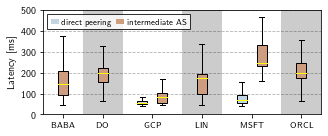

In [66]:
country = "BH"
target_country = "IN"

def adjust_box(plot, index, pt):
    plt.setp(plot['boxes'][index], facecolor=type_colors[pt], linewidth=1)
    plt.setp(plot['medians'][index], color='yellow')

type_colors = {0: cols[0], 1: cols[1]}
latencies = {}

for row in df_ixp_max.itertuples(index=False):
        src = row.source.split(":")[0]
        prov = row.provider
        ids = [y for x in eval(row.ids) for y in x] if type(eval(row.ids)) == tuple else eval(row.ids)
        lats = [y for x in ids for y in tracert_latencies[x] if tracert_dest[x] == target_country]
        if prov not in latencies:
            latencies[prov] = {}
        pt = 0 if row.intermediate == 0 else 1
        if pt not in latencies[prov]:
            latencies[prov][pt] = []
        latencies[prov][pt] += lats
        
fig, ax = plt.subplots(figsize=(4.66, 2))
counter = 0
tick_pos = []
for prov in sorted(latencies.keys()):
    pts = list(filter(lambda x: len(latencies[prov][x]) > 10, sorted(latencies[prov].keys())))
    data = [latencies[prov][x] for x in pts]
    positions = np.arange(counter, counter + len(pts))
    if len(data) > 0:
        bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
        for i, pt in enumerate(pts):
            adjust_box(bp, i, pt)
        tick_pos.append((counter + counter + len(pts) - 1)/2)
        counter += len(pts) + 1
    else:
        del latencies[prov]
    
ax.set_xticks(tick_pos)
ax.set_xticklabels([provider_abbrev[x] for x in sorted(latencies.keys())], fontsize="small")
ax.set_xlim([-1,13])
ax.set_ylabel("Latency [ms]")
ax.set_yticks(np.arange(0,600,100))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.axvspan(1, 3, facecolor="k", alpha=0.2)
ax.axvspan(6, 8, facecolor="k", alpha=0.2)
ax.axvspan(11, 13, facecolor="k", alpha=0.2)

legend_keys = []
legend_labels = ["direct peering", "intermediate AS"]
for pt in type_colors:
    legend_keys.append(Patch(facecolor = type_colors[pt]))

ax.legend(legend_keys, legend_labels, loc="upper left",
           ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False, fontsize="small")
plt.grid(True, axis="y", linestyle="--")

fig.tight_layout()
plt.savefig("Figs/Fig_19b.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 14 - Vantage point density heatmap of all Speedchecker probes

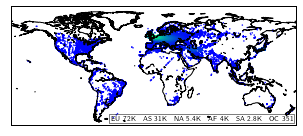

In [67]:
cursor.execute("""select Latitude, Longitude from Probes where ProbeID in (SELECT distinct(ProbeID)
from Ping union select distinct(ProbeID) from Traceroute) 
and Country is not NULL and Country != '' and Latitude is not NULL and Longitude is not NULL""")
lat, lon = [], []
for la, lo in cursor:
    lat.append(la)
    lon.append(lo)
    
fig, ax = plt.subplots(figsize=(4.66, 2))

m = Basemap(projection='cyl',llcrnrlat=-60,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='l', ax=ax)

m.drawcoastlines()
m.drawmapboundary(fill_color='white') 

x, y = m(lon, lat)
x = np.array(x)
y = np.array(y)
    
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

points=ax.scatter(x, y, c=z, s=1, marker='.', cmap='winter')
ax.text(0.35, 0.03, "EU 72K\ \ \ AS 31K\ \ \ NA 5.4K\ \ \ AF 4K\ \ \ SA 2.8K\ \ \ OC 351", 
        transform=ax.transAxes, fontsize="x-small", verticalalignment="bottom", 
        bbox=dict(boxstyle="Square, pad=0.25", facecolor="none", edgecolor="black", lw=0.5))

plt.savefig("Figs/Fig_14.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("Figs/Fig_14.png", dpi=500, bbox_inches="tight", pad_inches=0)
plt.show()

# Figure 15 - ICMP vs TCP latency comparison

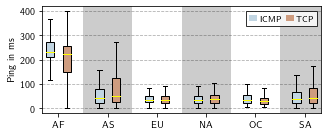

In [68]:
tcp_pings = get_lowest_avg_ping_unfiltered_geo("tcp", country=False, glob=True)
icmp_pings = get_lowest_avg_ping_unfiltered_geo("icmp", country=False, glob=True)

fig, ax = plt.subplots(figsize=(4.66,2))
counter = 0
tick_pos = []
for cont in continents:
    data = [list(filter(lambda x: x < 400, tcp_pings[cont])), list(filter(lambda x: x < 400, icmp_pings[cont]))]
    positions = np.arange(counter, counter + 2)
    bp = ax.boxplot(data, positions=positions, widths=0.5, showfliers=False, patch_artist=True)
    for index in (0, 1):
        plt.setp(bp['boxes'][index], facecolor=cols[index])
        plt.setp(bp['medians'][index], color='yellow')
    tick_pos.append((counter + counter + 1)/2)
    counter += 3
    
xspan = 3
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(continents))
    if i % 2 == 1]

ax.set_xticks(tick_pos)
ax.set_xticklabels(continents)
ax.set_ylabel("Ping in ms")
ax.set_xlim([-0.5, 3 * len(continents) - 1.5])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=cols[0]), Patch(facecolor=cols[1])]
labels = ["ICMP", "TCP"]

ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="upper right", fancybox=False, edgecolor="k", fontsize="small", ncol=3)

plt.grid(True, axis='y', linestyle='--')

plt.savefig("Figs/Fig_15.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()

# Figure 16 - (City, ASN, Datacenter) latency comparison between RIPE Atlas and Speedchecker

## Data preparation

In [69]:
hops_sql = """select TracerouteID, City, ASN from Hops H join NodeInfo N on H.HopIP = N.IP where 
           City != 'Unknown' and ASN != -1 and HopNumber = 2"""

tracert_latency_sql = """with ranked_hops as (
                      select TracerouteID, RTT1, RTT2, RTT3, ROW_NUMBER() OVER 
                      (PARTITION BY TracerouteID ORDER BY HopNumber DESC) AS rn FROM Hops
                      WHERE TracerouteID IN {}),
                      tracert_id_info AS (
                      SELECT TracerouteID, DestinationURL FROM Traceroute T
                      JOIN Datacenters D on D.URL = T.DestinationURL  where TracerouteID in {})
                      SELECT RTT1, RTT2, RTT3, DestinationURL, R.TracerouteID FROM ranked_hops R JOIN 
                      tracert_id_info T ON R.TracerouteID = T.TracerouteID WHERE rn = 1"""

location_info = {}
cursor.execute(hops_sql)
for t_id, city, asn in cursor:
    location_info[t_id] = (city, asn)

r_ids = tuple(location_info.keys())
cursor.execute(tracert_latency_sql.format(r_ids, r_ids))
latencies = collections.defaultdict(lambda: collections.defaultdict(list))
for row in cursor:
    lats = [x for x in row[:3] if x and 0 < x < 1000]
    latencies[row[3]][location_info[row[4]]] += lats
    
hops_sql = """with relevant_ids as (
           select TI.ID from TracerouteInfo TI join Traceroute T on TI.ID = T.ID join Probes P on
           TI.probe_id = P.ID where protocol = 'ICMP' and P.home = 1)
           select Traceroute_ID, City, ASN from Hops H join NodeInfo N on H.dst_ip = N.IP
           where City is not null and City != 'unknown' and City != 'Unknown' and ASN is not null and
           hop_number = 2 and attempt = 0 and Traceroute_ID in relevant_ids"""

tracert_latency_sql = """with ranked_hops AS ( 
                      SELECT Traceroute_ID, rtt_after, ROW_NUMBER() OVER  
                      (PARTITION BY Traceroute_ID, attempt ORDER BY hop_number DESC) AS rn FROM Hops  
                      WHERE Traceroute_ID IN {}), 
                      tracert_id_info AS ( 
                      SELECT TI.ID, TI.url FROM TracerouteInfo TI JOIN Datacenter D on 
                      TI.datacenter = D.ID where TI.ID in {})
                      SELECT rtt_after, url, R.Traceroute_ID 
                      name FROM ranked_hops R JOIN tracert_id_info T  
                      ON R.Traceroute_ID = T.ID WHERE rn = 1"""

location_info_ripe = {}
cursor_ripe.execute(hops_sql)
for t_id, city, asn in cursor_ripe:
    location_info_ripe[t_id] = (city, asn)

r_ids_ripe = tuple(location_info_ripe.keys())
cursor_ripe.execute(tracert_latency_sql.format(r_ids_ripe, r_ids_ripe))
latencies_ripe = collections.defaultdict(lambda: collections.defaultdict(list))
for row in cursor_ripe:
    latencies_ripe[row[1]][location_info_ripe[row[2]]].append(row[0])

matches = {}
for url in latencies:
    if url in latencies_ripe:
        tuples = latencies[url].keys() & latencies_ripe[url].keys()
        if tuples:
            matches[url] = tuples
            
cities_sql = """select distinct City, Continent from NodeInfo where City is not null and City != 'Unknown'"""
cursor.execute(cities_sql)

city_map = {}
for city, cont in cursor:
    city_map[city] = cont

data = collections.defaultdict(list)
for url in matches:
    for tup in matches[url]:
        if len(latencies[url][tup]) > 5 and len(latencies_ripe[url][tup]) > 5:
            data[city_map[tup[0]]].append(np.median(latencies[url][tup]) - np.median(latencies_ripe[url][tup]))

## Plot

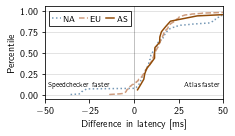

In [70]:
fig, ax = plt.subplots(figsize=(3.37,2))
ax.axvline(x=0, linewidth=0.8, color="black", linestyle="-", alpha=0.3)
for cont in data:
    xs = np.sort(data[cont])
    ys = np.arange(1, len(data[cont]) + 1) / len(data[cont])
    ax.plot(xs, ys, label=cont, color=continent_colors[cont], linestyle=lstyles[cont])
ax.set_xlabel("Difference in latency [ms]")
ax.set_ylabel("Percentile")
ax.set_xlim([-50,50])
ax.set_xticks(range(-50, 75, 25))
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False
ax.legend(loc="upper left", fontsize="small", ncol=3, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis="y", linestyle="-", alpha=0.7, linewidth=0.5)

ax.text(-48, 0.1, "Speedchecker faster", fontsize="x-small")
ax.text(28, 0.1, "Atlas faster", fontsize="x-small")

plt.savefig("Figs/Fig_16.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()